# Исследование объявлений о продаже квартир

В проекте используются данные сервиса Яндекс Недвижимость — архив объявлений за несколько лет о продаже квартир в Санкт-Петербурге и соседних населённых пунктах.

Задача — выполнить предобработку данных и изучить их, найти интересные особенности и зависимости, которые существуют на рынке недвижимости.

О каждой квартире в базе содержится два типа данных: добавленные пользователем и картографические. Например, к первому типу относятся площадь квартиры, её этаж и количество балконов, ко второму — расстояния до центра города, аэропорта и ближайшего парка.  

### Загрузка данных и изучение общей информации

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv(
    'C:/DataAnalysis/initial_data/project_3/real_estate_data.csv',
    sep = '\t')

In [3]:
data.head(5) # знакомство с массивом данных

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [4]:
data.info() # знакомство с массивом данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

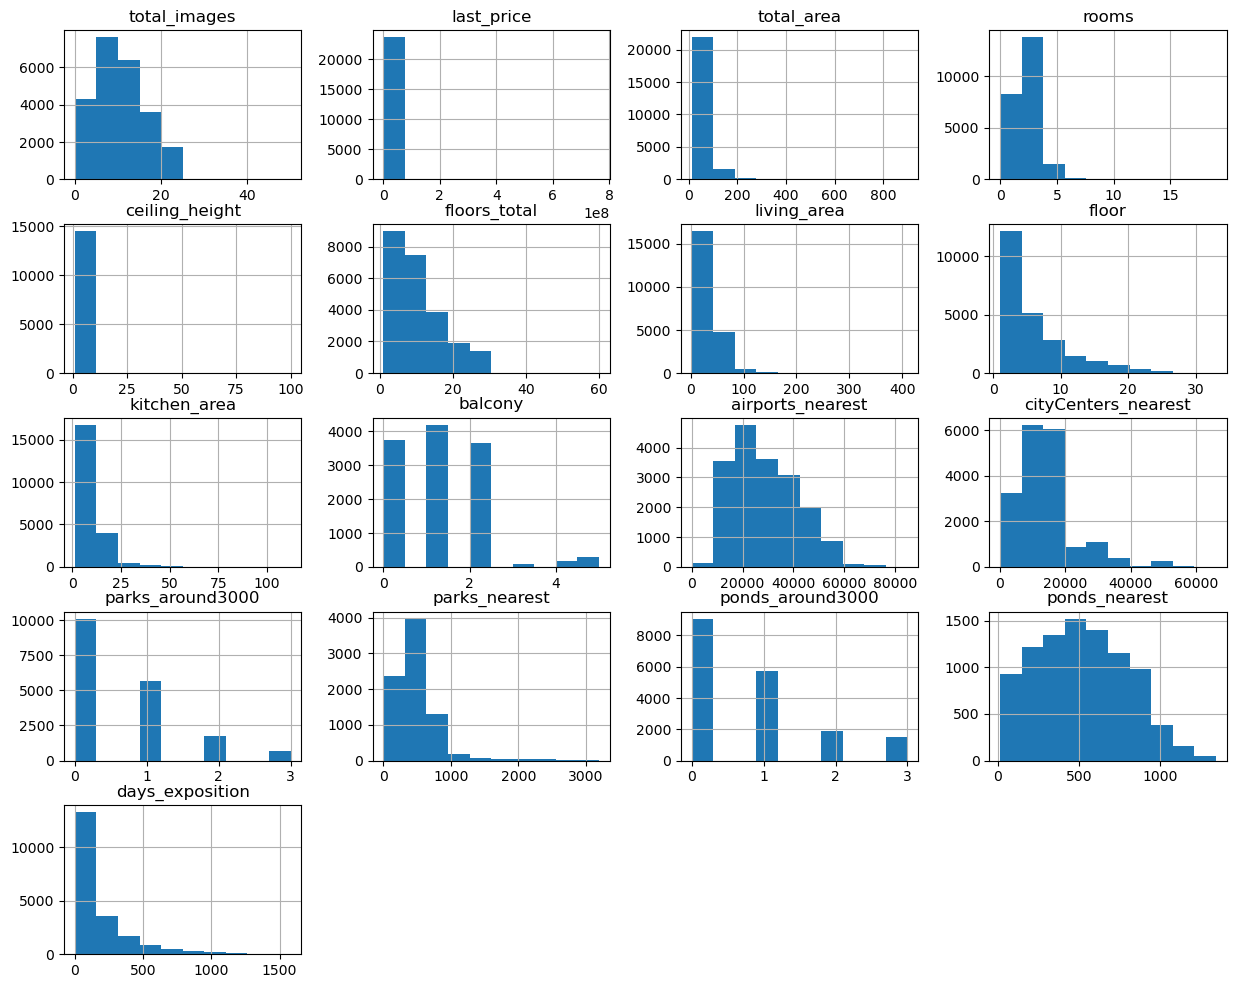

In [5]:
# построение общей гистограммы для всех числовых столбцов таблицы
data.hist(figsize=(15, 12));

#### Краткое резюме архив объявлений real_estate_data.csv
Таблица содержит 22 столбца с пользовательской и картографической информацией. 

Количество строк 23699. Неполная информация содержится более чем в половине столбцов (менее 23699 значений).

Выведены гистограммы по 17 количественным параметрам. В первом приближении вызывает сомнения корректность информации в столбцах rooms - в части количества 5+ комнат, сeiling_height - встречаются данные с высотой до 100м, а также в данных по площадям (total_area, living_area, kitchen_area) - кухни в 100м2 и общая площадь 800м2+.

### Предобработка данных

#### 1. Пропуски. Поиск и изучение пропущенных значений в столбцах

In [6]:
# определение, в каких столбцах есть пропуски
data.isna().sum().sort_values(ascending=False)

is_apartment            20924
parks_nearest           15620
ponds_nearest           14589
balcony                 11519
ceiling_height           9195
airports_nearest         5542
cityCenters_nearest      5519
ponds_around3000         5518
parks_around3000         5518
days_exposition          3181
kitchen_area             2278
living_area              1903
floors_total               86
locality_name              49
total_images                0
last_price                  0
studio                      0
floor                       0
rooms                       0
first_day_exposition        0
total_area                  0
open_plan                   0
dtype: int64

#### Предварительный анализ столбцов с пропущенными значениями
(имя столбца / всего пропусков / дальнейшее действие)

*is_apartment / 20924 / без изменений*

Булев тип данных, показывает, является ли недвижимость апартаментами или нет (среди заполненных значений есть как True, так и False). Предположить, чем заполнить пустые значения по данным других столбцов невозможно.
Если данная информация будет критична для дальнейшего анализа - можно будет сделать предположение, что все пропуски не являются апартаментами, т.к. статус "апартаменты" имеет низкий процент объектов в РФ (general knowledge), можно проверить эту гипотезу, оценив долю True среди заполненных значений.  

Возможные причины пропусков: человеческий фактор - отсутствие информации о статусе недвижимости у заполняющего, технический - ошибка при выгрузке данных, либо склеивании в общую таблицу.



*balcony / 11519 / замена на 0*

числовой тип данных, указано количество балконов. Предположение - пропущены значения объектов с отсутствием балконов. Действие - замена пустых значений на 0.

Возможные причины пропусков: наиболее вероятен человеческий фактор, графа просто пропускалась при отсутствии балкона в объекте. 



*ceiling_height / 9195 / без изменений*

числовой тип данных, указана высота потолков. Предположить, чем заполнить пустые значения по данным других столбцов невозможно.

Возможные причины пропусков: физическое отсутствие замера, технический фактор - ошибка при выгрузке данных, либо склеивании в общую таблицу.


*days_exposition / 3181 / без изменений*

числовой тип данных, сколько дней было размещено объявление (от публикации до снятия). Предположение - пропущены значения объектов, публикации о которых на момент выгрузки данных не были сняты. Столбец first_day_exposition не имеет пропусков, таким образом, с помощью него можно выполнить расчеты для заполнения наиболее вероятного значения для days_exposition. Возможные действия:
1. Поиск самой поздней даты, зафиксированной в массиве данных через расчет: дата первой публикации + количество дней размещения объявления, сортировка. Принятие этой даты за дату, наиболее близкую к дате формирования массива данных. Расчет пропусков количества дней размещения объявление: последняя дата (расчетная) отнять первую дату публикации.
2. Альтернатива - проигнорировать пропуск при отсутствии важности данного параметра 

Возможные причины пропусков: объявление не снято с публикации, технический фактор - не произведен расчет разница между датой публикации и датой снятия. Так же возможен вариант с фактической продажей квартиры без уведомления Яндекс Недвижимости (например, через альтернативный сервис). 

В данном случае предполагаем, что такой вариант невозможен и сотрудники Яндекса имеют полную информацию о статусе объектов в их базе.


*kitchen_area / 2278 / расчет*

числовой тип данных, площадь кухни. Используя имеющиеся данные по общей площади объекта и непропущенным данным по площади кухни, заполнение пропусков возможно статистически по следующему алгоритму: 
1. оценка доли площади кухни от общей площади для каждого из объектов
2. расчет медианного значения доли площади кухни по всем объектам (как наименее подверженного "выбросам")
3. расчет пропущенных значений предполагаемой площади кухни с помощью общей площади каждого из объектов, исключая пропуски у строк, где признак studio является True

Возможные причины пропусков: человеческий фактор - отсутствие информации о статусе недвижимости у заполняющего, технический - ошибка при выгрузке данных, либо склеивании в общую таблицу, физическое отсутствие отдельной классической кухни в квартирах студиях


*living_area / 1903  / расчет*

числовой тип данных, жилая площадь. Расчет аналогично площади кухни, кроме пункта об признаке "studio"



*floors_total / 86 / без изменений*

числовой тип данных, всего этажей в доме. Теоретически, столбец floor не имеет пропусков, таким образом, с помощью него можно выполнить расчет минимального количества этажей в доме, приняв floor как наиболее высокий известный показатель. Из минусов подобного предположения - мы решаем, что текущий этаж последний, что может быть не так. Для некоторых покупателей последний этаж может быть критерием для отказа от рассмотрения потенциального объекта покупки. Таким образом, т.к. количество пропусков невелико, принято решение об игнорировании пропусков.

Возможные причины пропусков: человеческий фактор - отсутствие информации о статусе недвижимости у заполняющего, технический - ошибка при выгрузке данных, либо склеивании в общую таблицу


*locality_name / 49 / без изменений*

категориальный тип данных, название населённого пункта. При наличии координат объекта, возможно восполнить название географического пункта. В рамках данного проекта, вероятно, придется оставить пропуски. 

Возможные причины пропусков: человеческий фактор - отсутствие информации о статусе недвижимости у заполняющего, технический - ошибка при выгрузке данных, либо склеивании в общую таблицу


***картографические данные / без изменений***

*parks_nearest / 15620*

*ponds_nearest / 14589*

*airports_nearest / 5542*

*cityCenters_nearest / 5519*

*ponds_around3000 / 5518*

*parks_around3000 / 5518*

либо не указаны координаты недвижимости, поэтому расчет расстояние не осуществлен, либо рядом нет искомого объекта. Без дополнительной информации заполнить пустые значения невозможно.

Возможные причины пропусков: наиболее вероятен технический фактор и действительно не сняты координаты объектов, либо не произведен расчет. Также нельзя исключать физическое отсутствие указанных объектов рядом с недвижимостью.


In [7]:
# функция визуализации пропущенных

def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,8), rot = -5, legend = False, fontsize = 16)
            .set_xlabel('% пропусков', fontsize = 18)
            .set_title('Количество пропусков по столбцам' + "\n", fontsize = 22, color = 'SteelBlue')
        );    
    except:
        print('пропусков не осталось :) или произошла ошибка в первой части функции ')

пропусков не осталось :) или произошла ошибка в первой части функции 


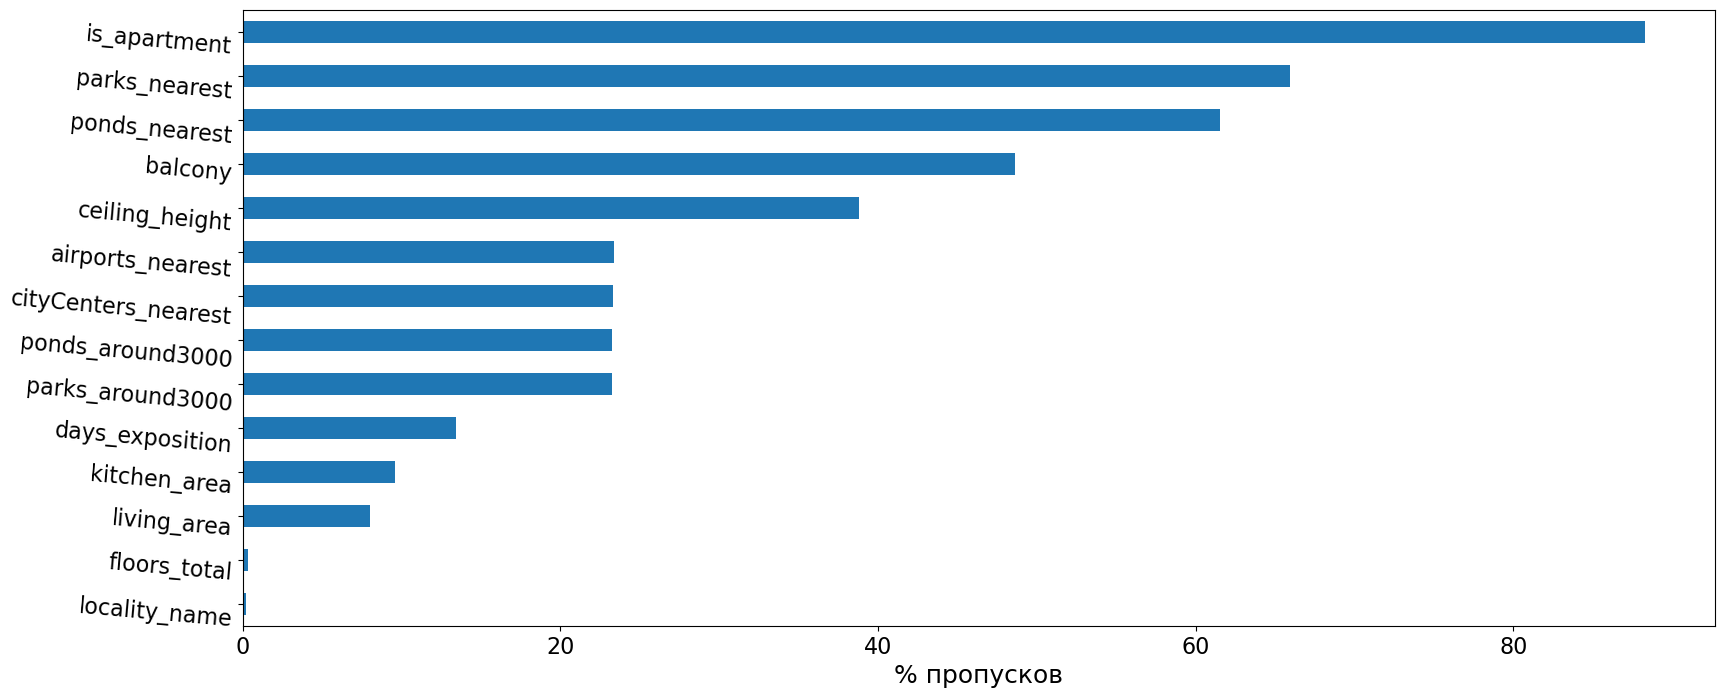

In [8]:
pass_value_barh(data)

In [9]:
# заполнение пропусков в balcony
data['balcony'].unique() # определяем, чем именно заполнены пропуски

array([nan,  2.,  0.,  1.,  5.,  4.,  3.])

In [10]:
data['balcony'] = data['balcony'].fillna(0) # заполняем nan нулями
display(data['balcony'].unique()) # проверка замены
print('Из 11519 пропусков осталось', data['balcony'].isna().sum()) # проверка кол-ва оставшихся пропусков

array([0., 2., 1., 5., 4., 3.])

Из 11519 пропусков осталось 0


In [11]:
print(len(data.query('total_area*0.9 <= (living_area + kitchen_area)'))) # фильтр 1
print(len(data.query('total_area < (living_area + kitchen_area)')))      # фильтр 2  

475
64


In [12]:
temp = ((data['kitchen_area'] + data['living_area'])/data['total_area']) 
temp = temp[temp>1]
temp.mean()

1.1455576913847747

#### 2. Типы данных в каждом из столбцов

In [13]:
data.dtypes # вывод типов объектов для каждого столбца

total_images              int64
last_price              float64
total_area              float64
first_day_exposition     object
rooms                     int64
ceiling_height          float64
floors_total            float64
living_area             float64
floor                     int64
is_apartment             object
studio                     bool
open_plan                  bool
kitchen_area            float64
balcony                 float64
locality_name            object
airports_nearest        float64
cityCenters_nearest     float64
parks_around3000        float64
parks_nearest           float64
ponds_around3000        float64
ponds_nearest           float64
days_exposition         float64
dtype: object

***Столбцы, в которых необходимо выполнить изменения типа данных:***

first_day_exposition - object изменить на дату, необходимость обусловлена невозможностью корректно работать с данными object в дальнейшем, например, проводить расчеты по временным отрезкам

***Столбцы, в которых возможно выполнить изменения типа данных, но этапе предобработки данных однозначного ответа о целесообразности данной операции нет:***

floors_total, balcony - float возможно изменить на int, количество этажей и балконов не может быть дробным числом, так же тип данных int позволяет потенциально произвести больше операций, чем float. Изменение типа данных производится быстро. 

Но в дальнейшем при работе с конвертированными данными типа Int64 возникает проблема работы функции для категоризации значений там, где присутствуют пропуски (ошибка "boolean value of NA is ambiguous"). Таким образом, дополнительно удалим строки с пустыми значениями, чтобы исключить ошибку. 

is_apartment - тип данных object, корректно будет изменить на bool, но т.к. простой способ .astype(bool) приводит к заполнению  пропущенных значений как True (Nan, более 20 тысяч значений, 88% от общего количества), то работа по смене формата будет целесообразна в том случае, если имеющийся небольшой массив данных понадобится в дальнейшем




In [14]:
# столбец first_day_exposition имеет тип object, преобразуем его в datetime
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%dT%H:%M:%S')

In [15]:
# преобразование из float в int
data['floors_total'] = data['floors_total'].astype('Int64')
data['balcony'] = data['balcony'].astype('Int64')

In [16]:
data.dtypes # проверка изменений

total_images                     int64
last_price                     float64
total_area                     float64
first_day_exposition    datetime64[ns]
rooms                            int64
ceiling_height                 float64
floors_total                     Int64
living_area                    float64
floor                            int64
is_apartment                    object
studio                            bool
open_plan                         bool
kitchen_area                   float64
balcony                          Int64
locality_name                   object
airports_nearest               float64
cityCenters_nearest            float64
parks_around3000               float64
parks_nearest                  float64
ponds_around3000               float64
ponds_nearest                  float64
days_exposition                float64
dtype: object

#### 3. Устранение неявных дубликатов

In [17]:
print(len(data['locality_name'].unique()))  # определение кол-ва уникальных значений в locality_name
data.sort_values('locality_name')['locality_name'].unique() # определение уникальных значений в locality_name, 
                                                                   # предварительно отсортировав их по алфавиту

365


array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Янино-1',
       'городской посёлок Будогощь', 'городской посёлок Виллози',
       'городской посёлок Лесогорский', 'городской посёлок Мга',
       'городской посёлок Назия', 'городской посёлок Новоселье',
       'городской посёлок Павлово', 'городской посёлок Рощино',
       'городской посёлок Свирьстрой', 'городской посёлок Совет

In [18]:
# унификация географических названий

# этап 1, меняем "ё" на "е"
data['locality_name'] = data['locality_name'].str.replace('ё','е') 

# этап 2
data['locality_name'] = data['locality_name'].str.replace('городской поселок','поселок') 
data['locality_name'] = data['locality_name'].str.replace('деревня','поселок') 
data['locality_name'] = data['locality_name'].str.replace('поселок городского типа','поселок') 
data['locality_name'] = data['locality_name'].str.replace('село ','поселок ') # чтобы "поселок" не заменилось на 'попоселокк' 

# этап 3
data['locality_name'] = data['locality_name'].str.replace('поселок при железнодорожной станции','поселок при ж/д станции') 
data['locality_name'] = data['locality_name'].str.replace('поселок станции','поселок при ж/д станции') 

# этап 4
data['locality_name'] = data['locality_name'].str.replace('садоводческое некоммерческое товарищество','садовое товарищество') 

# определение уникальных значений в locality_name, предварительно отсортировав их по алфавиту
print(len(data['locality_name'].unique()))
data.sort_values('locality_name')['locality_name'].unique()


314


array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалево',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'коттеджный поселок Кивеннапа Север', 'коттеджный поселок Лесное',
       'коттеджный поселок Счастье', 'поселок Агалатово',
       'поселок Александровская', 'поселок Алексеевка', 'поселок Аннино',
       'поселок Аро', 'поселок Барышево', 'поселок Батово',
       'поселок Бегуницы', 'поселок Белогорка', 'поселок Белоостров',
       'поселок Большая Вруда', 'поселок Большая Ижора',
 

In [19]:
# check
data.locality_name.nunique()

313

После переименования неявных дубликатов из 365 уникальных названий осталось 314 (обработан 51 дубликат).
В тоже время, в базе имеется порядка 8 похожих наименований объектов, по которым невозможно однозначно определить, в одном ли географическом пункте находятся. Это:

* поселок Громово / поселок при ж/д станции Громово

* поселок Кудрово / Кудрово

* коттеджный поселок Лесное / поселок Лесное

* поселок Любань / Любань

* поселок Мурино / Мурино

* поселок Никольское / Никольское

* поселок Приладожский / Приладожский

* поселок Рахья / Рахья

Предпросмотр остальных столбцов не позволяет сделать вывод, в одном ли нас пункте находятся эти пары объектов, т.к. почти по всем пунктам выше отсутствует картографическая информация. 

В рамках данного проекта сделано допущение, что это разные населенные пункты. Но при этом, в дальнейшем анализе будем держать в уме, что такие объекты есть и будем учитывать это при тех или иных выводах.


In [20]:
data.duplicated().sum() # проверка на наличие явных дубликатов

0

#### 4. Устранение редких и выбивающихся значений

##### 4.1 Общий анализ

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        14504 non-null  float64       
 6   floors_total          23613 non-null  Int64         
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          2775 non-null   object        
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

In [22]:
data['billion_price'] = data.last_price/1000000       # колонка для перевода стоимости недвижимости в млн руб

In [23]:
# датасет с мин/макс/средним/медианным значением у всех пользовательских числовых параметров
(
    data[['billion_price', 'total_area', 'rooms','ceiling_height','floors_total','living_area','floor','kitchen_area',
          'balcony','days_exposition']]
    .apply (['count', 'min', 'max', 'median', 'mean'])   
    .style.format("{:,.0f}")
)

,billion_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,days_exposition
count,"23,699","23,699","23,699","14,504","23,613","21,796","23,699","21,421","23,699","20,518"
min,0,12,0,1,1,2,1,1,0,1
max,763,900,19,100,60,410,33,112,5,"1,580"
median,5,52,2,3,9,30,4,9,0,95
mean,7,60,2,3,11,34,6,11,1,181


In [24]:
# Значения параметров объектов недвижимости на разных квантилях
(
    data[['billion_price', 'total_area', 'rooms','ceiling_height','floors_total','living_area','floor','kitchen_area',
          'balcony','days_exposition']]
    .quantile([0.0012, 0.01, .5, .99, .9988]) # выбираем размах в 0,9976 квантилей 
    .style.format("{:,.2f}")
)

,billion_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,days_exposition
0.001200,0.56,20.00,0.00,2.30,2.00,10.00,1.00,3.77,0.00,3.00
0.010000,1.00,25.20,1.00,2.50,2.00,13.00,1.00,5.00,0.00,4.00
0.500000,4.65,52.00,2.00,2.65,9.00,30.00,4.00,9.10,0.00,95.00
0.990000,36.00,197.21,5.00,3.83,26.00,120.00,23.00,35.09,5.00,"1,068.66"
0.998800,124.77,380.00,8.00,25.00,35.00,219.69,26.00,60.00,5.00,"1,369.90"


##### 4.2 ***Рассмотрим каждый из параметров отдельно***

###### 4.2.1 Цена на момент снятия с публикации


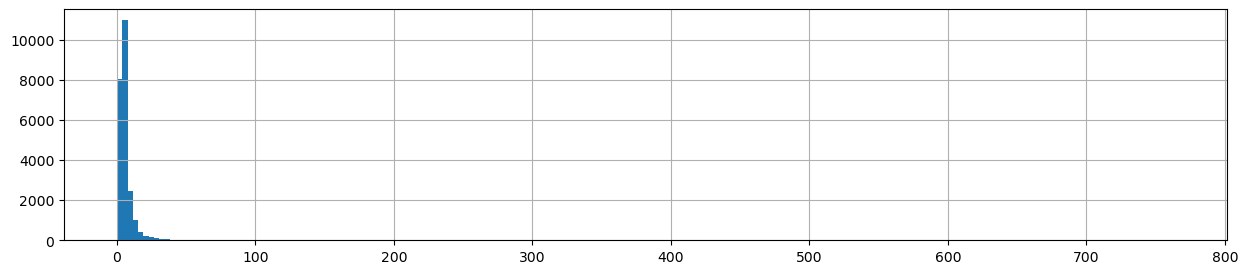

In [25]:
data.billion_price.hist(bins = 200, figsize = (15,3)); # общий график не презентабелен

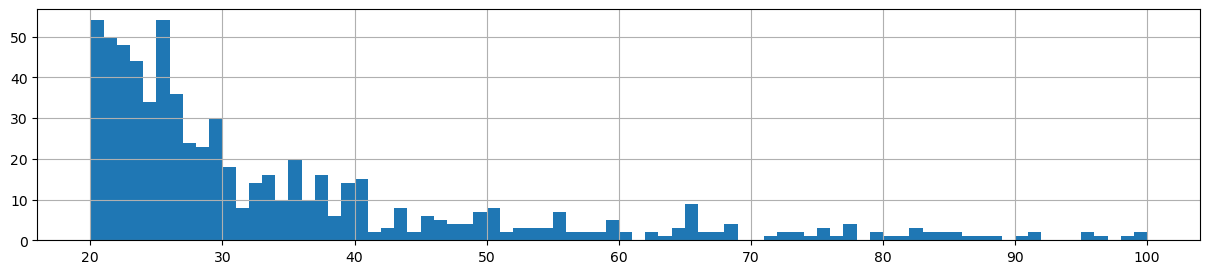

In [26]:
data.billion_price.hist(bins = 80, figsize = (15,3), range = (20,100)); # зум на больших значениях

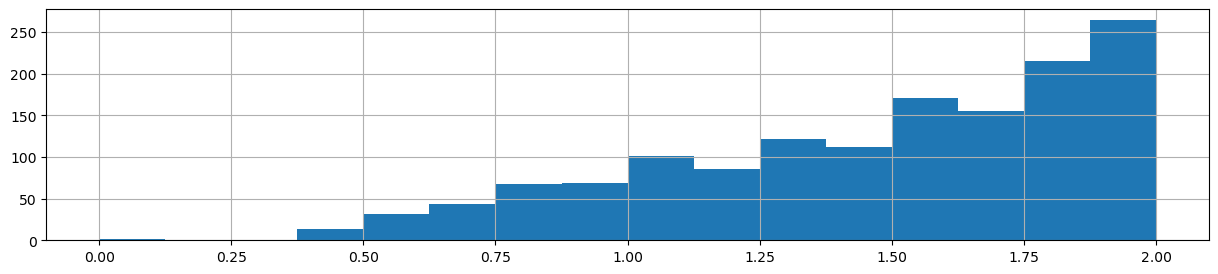

In [27]:
data.billion_price.hist(bins = 16, figsize = (15,3), range = (0,2)); # зум на мелких значениях

Согласно гистограммам выше, принимаем, что цены менее 600тыс и более 45млн с большой долей уверенности можно считать редкостями.

Данные критерии отсечения попадают в диапазон между квантилями 0.0012, 0.01 и .99, .9988 соответственно.


In [28]:
# замена выбросов на Nan
data.loc[data['billion_price'] <= 0.6, 'billion_price'] = data.loc[data['billion_price']=='nan', 'billion_price'] 
data.loc[data['billion_price'] >= 45, 'billion_price'] = data.loc[data['billion_price']=='nan', 'billion_price'] 

# проверка условия фильтрации значений - не более 1% данных от изначального объема
print(1-(data.billion_price.count()/data.last_price.count()))
print(data.last_price.count()-data.billion_price.count())

0.008776741634668128
208


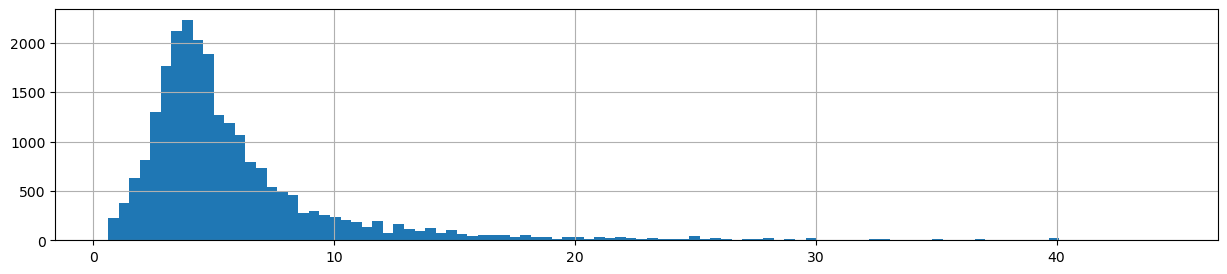

In [29]:
data.billion_price.hist(bins = 100, figsize = (15,3)); # общий график после фильтрации

Резюме по устранению редких и выбивающихся значений параметра: удалено 208 цен, что составляет чуть более 0.8% значений.

###### 4.2.2 Общая площадь квартиры

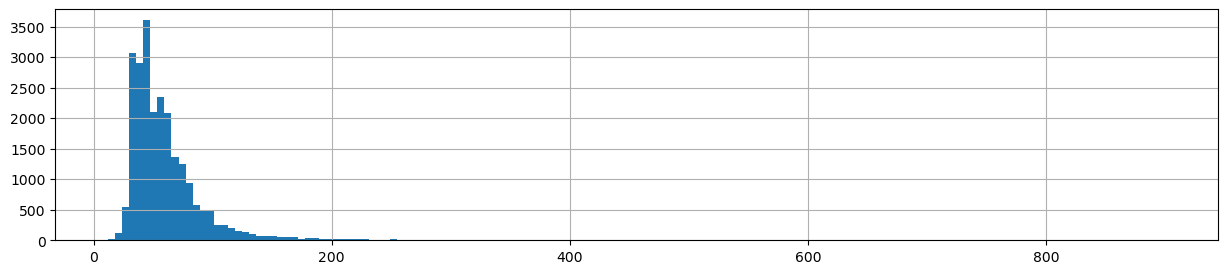

In [30]:
data.total_area.hist(bins = 150, figsize = (15,3)); # общий график не презентабелен

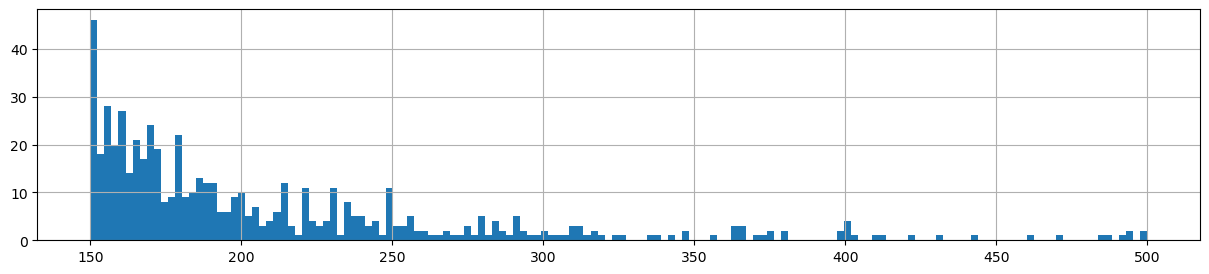

In [31]:
data.total_area.hist(bins = 150, figsize = (15,3), range = (150,500)); # зум1 на больших значениях

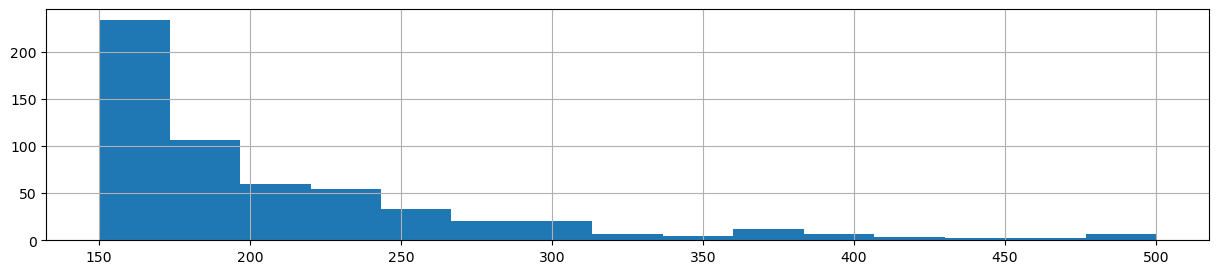

In [32]:
data.total_area.hist(bins = 15, figsize = (15,3), range = (150,500)); # зум2 на больших значениях

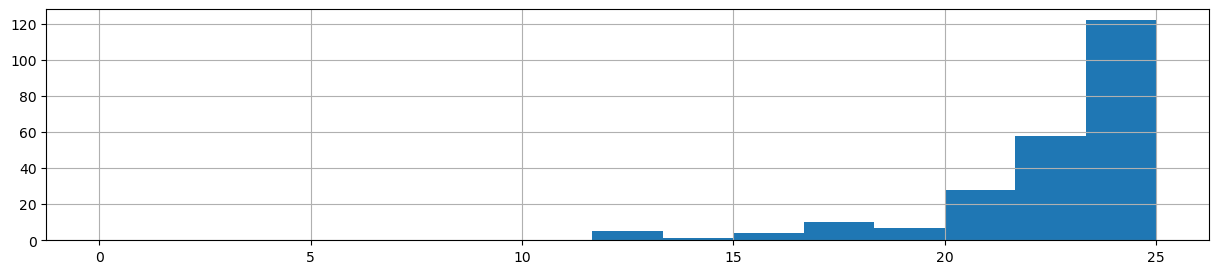

In [33]:
data.total_area.hist(bins = 15, figsize = (15,3), range = (0,25)); # зум1 на больших значениях

Согласно гистограммам выше, принимаем, что площади менее 20м2 и более 250м2 с большой долей уверенности можно считать редкостями.

Данные критерии отсечения попадают в диапазон между квантилями 0.0012, 0.01 и .99, .9988 соответственно.

In [34]:
# создание нового столбца и замена выбросов на Nan
data['total_area2'] = data['total_area']
data.loc[data['total_area2'] <= 20, 'total_area2'] = data.loc[data['total_area2']=='nan', 'total_area2'] 
data.loc[data['total_area2'] >= 250, 'total_area2'] = data.loc[data['total_area2']=='nan', 'total_area2'] 

# проверка условия фильтрации значений - не более 1% данных от изначального объема
print(1-(data.total_area2.count()/data.total_area.count()))
print(data.total_area.count()-data.total_area2.count())

0.006371576859783068
151


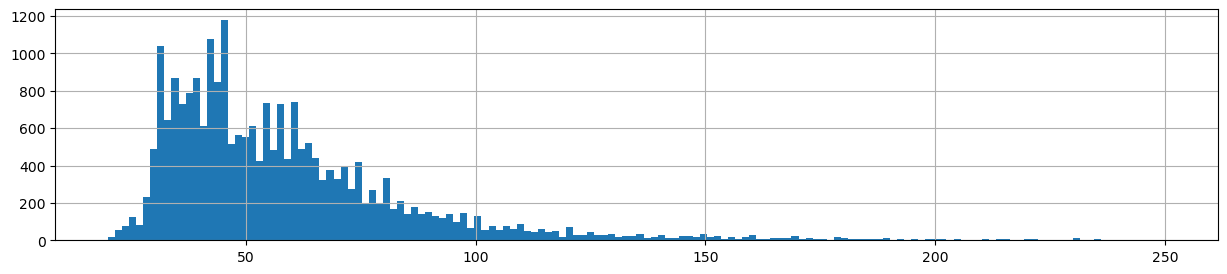

In [35]:
data.total_area2.hist(bins = 150, figsize = (15,3)); # общий график после фильтрации

Резюме по устранению редких и выбивающихся значений параметра: удалено 150 площадей, что составляет чуть более 0.6% значений.

###### 4.2.3 Число комнат

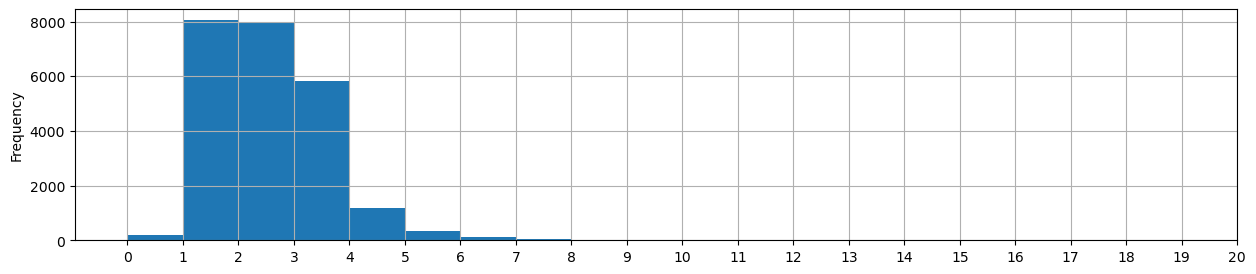

In [36]:
data.rooms.plot(kind = 'hist', bins = (19),figsize = (15,3), grid = True, 
                xticks = (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20));

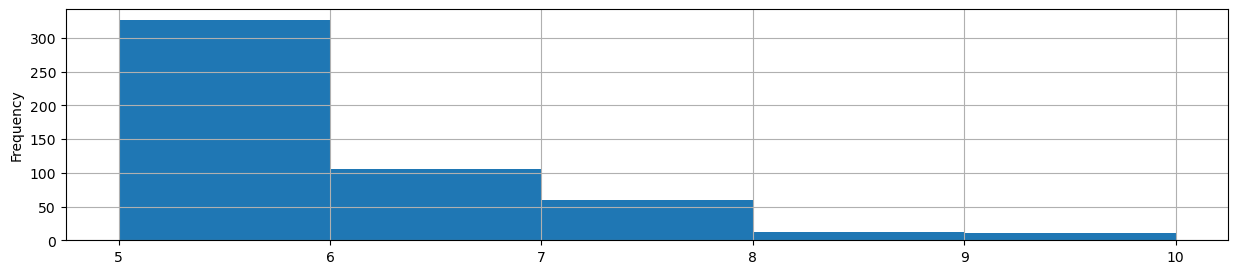

In [37]:
data.rooms.plot(kind = 'hist', bins = (5),figsize = (15,3), grid = True, range = (5,10),
                xticks = (5,6,7,8,9,10));

Согласно гистограммам выше, принимаем, что 0 комнат встречается достаточно часто, а количество комнат более 7 можно считать редкостью. Поэтому отсекать будет только максимальные значения.

Данные критерий отсечения соответствует квантилю .9988.

In [38]:
# создание нового столбца и замена выбросов на Nan
data['rooms2'] = data['rooms']
data.loc[data['rooms2'] > 7, 'rooms2'] = data.loc[data['rooms2']=='nan', 'rooms2'] 

# проверка условия фильтрации значений - не более 1% данных от изначального объема
print(1-(data.rooms2.count()/data.rooms.count()))
print(data.rooms.count()-data.rooms2.count())

0.0013080720705515025
31


In [39]:
data.rooms2.value_counts().to_frame()

,rooms2
1.0,8047
2.0,7940
3.0,5814
4.0,1180
5.0,326
0.0,197
6.0,105
7.0,59


Резюме по устранению редких и выбивающихся значений параметра: удалено 31 значение, что составляет чуть более 0.1% от исходных данных

###### 4.2.4 Высота потолков

In [40]:
data.ceiling_height.sort_values().unique()              # выведем уникальные значения высоты потолков

array([  1.  ,   1.2 ,   1.75,   2.  ,   2.2 ,   2.25,   2.3 ,   2.34,
         2.4 ,   2.45,   2.46,   2.47,   2.48,   2.49,   2.5 ,   2.51,
         2.52,   2.53,   2.54,   2.55,   2.56,   2.57,   2.58,   2.59,
         2.6 ,   2.61,   2.62,   2.63,   2.64,   2.65,   2.66,   2.67,
         2.68,   2.69,   2.7 ,   2.71,   2.72,   2.73,   2.74,   2.75,
         2.76,   2.77,   2.78,   2.79,   2.8 ,   2.81,   2.82,   2.83,
         2.84,   2.85,   2.86,   2.87,   2.88,   2.89,   2.9 ,   2.91,
         2.92,   2.93,   2.94,   2.95,   2.96,   2.97,   2.98,   2.99,
         3.  ,   3.01,   3.02,   3.03,   3.04,   3.05,   3.06,   3.07,
         3.08,   3.09,   3.1 ,   3.11,   3.12,   3.13,   3.14,   3.15,
         3.16,   3.17,   3.18,   3.2 ,   3.21,   3.22,   3.23,   3.24,
         3.25,   3.26,   3.27,   3.28,   3.29,   3.3 ,   3.31,   3.32,
         3.33,   3.34,   3.35,   3.36,   3.37,   3.38,   3.39,   3.4 ,
         3.42,   3.43,   3.44,   3.45,   3.46,   3.47,   3.48,   3.49,
      

In [41]:
# создание нового столбца и замена выбросов на Nan
data['ceiling_height2'] = data['ceiling_height']

# перенесем разделитель разрядов у 20м+ потолков 
data.loc[data['ceiling_height2']>=20, 'ceiling_height2' ] = data.loc[data['ceiling_height2']>=20,'ceiling_height2']/10

# затем заменяем наверняка нефизичные потолки на Nan
data.loc[data['ceiling_height2']>=6, 'ceiling_height2'] = data.loc[data['ceiling_height2']=='nan', 'ceiling_height2'] 

data.ceiling_height2.sort_values().unique() 

array([1.  , 1.2 , 1.75, 2.  , 2.2 , 2.25, 2.26, 2.3 , 2.34, 2.4 , 2.45,
       2.46, 2.47, 2.48, 2.49, 2.5 , 2.51, 2.52, 2.53, 2.54, 2.55, 2.56,
       2.57, 2.58, 2.59, 2.6 , 2.61, 2.62, 2.63, 2.64, 2.65, 2.66, 2.67,
       2.68, 2.69, 2.7 , 2.71, 2.72, 2.73, 2.74, 2.75, 2.76, 2.77, 2.78,
       2.79, 2.8 , 2.81, 2.82, 2.83, 2.84, 2.85, 2.86, 2.87, 2.88, 2.89,
       2.9 , 2.91, 2.92, 2.93, 2.94, 2.95, 2.96, 2.97, 2.98, 2.99, 3.  ,
       3.01, 3.02, 3.03, 3.04, 3.05, 3.06, 3.07, 3.08, 3.09, 3.1 , 3.11,
       3.12, 3.13, 3.14, 3.15, 3.16, 3.17, 3.18, 3.2 , 3.21, 3.22, 3.23,
       3.24, 3.25, 3.26, 3.27, 3.28, 3.29, 3.3 , 3.31, 3.32, 3.33, 3.34,
       3.35, 3.36, 3.37, 3.38, 3.39, 3.4 , 3.42, 3.43, 3.44, 3.45, 3.46,
       3.47, 3.48, 3.49, 3.5 , 3.51, 3.52, 3.53, 3.54, 3.55, 3.56, 3.57,
       3.58, 3.59, 3.6 , 3.62, 3.63, 3.65, 3.66, 3.67, 3.68, 3.69, 3.7 ,
       3.75, 3.76, 3.78, 3.8 , 3.82, 3.83, 3.84, 3.85, 3.86, 3.87, 3.88,
       3.9 , 3.93, 3.95, 3.98, 4.  , 4.06, 4.1 , 4.

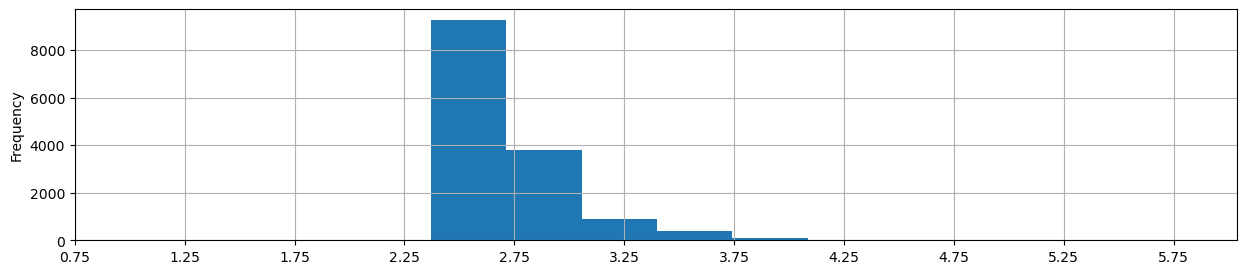

In [42]:
data.ceiling_height2.plot(kind = 'hist',bins = (14), figsize = (15,3), grid = True, 
                          xticks = (0.75,1.25,1.75,2.25,2.75,3.25,3.75,4.25,4.75,5.25,5.75));

Принимаем, что высота потолка менее 2.3м и более 4м с большой долей уверенности - редкости.

Критерии отсечения 2.3м попадает в диапазон между квантилями 0.0012, 0.01.

In [43]:
# замена выбросов на Nan
data.loc[data['ceiling_height2'] < 2.3, 'ceiling_height2'] = data.loc[data['ceiling_height2']=='nan', 'ceiling_height2'] 
data.loc[data['ceiling_height2'] > 4, 'ceiling_height2'] = data.loc[data['ceiling_height2']=='nan', 'ceiling_height2'] 

# проверка условия фильтрации значений - не более 1% данных от изначального объема
print(1-(data.ceiling_height2.count()/data.ceiling_height.count()))
print(data.ceiling_height.count()-data.ceiling_height2.count())

0.0048952013237727465
71


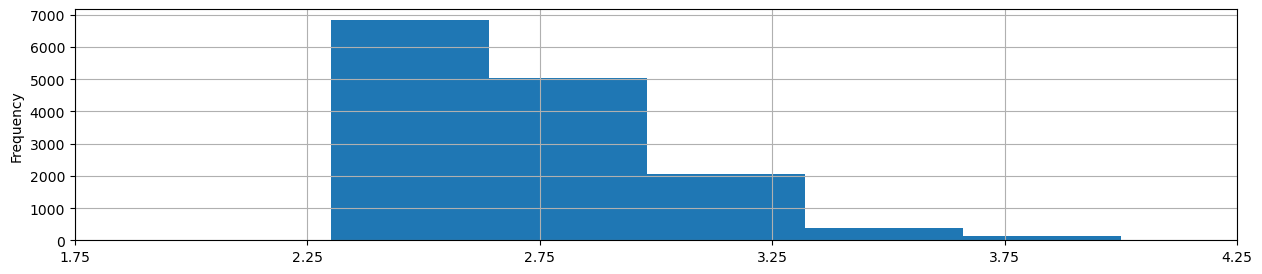

In [44]:
data.ceiling_height2.plot(kind = 'hist',bins = (5), figsize = (15,3), grid = True, 
                          xticks = (1.75,2.25,2.75,3.25,3.75,4.25));

Резюме по устранению редких и выбивающихся значений параметра: суммарно удалено 71 значение, что составляет около 0.5% от исходных данных

###### 4.2.5 Всего этажей в доме

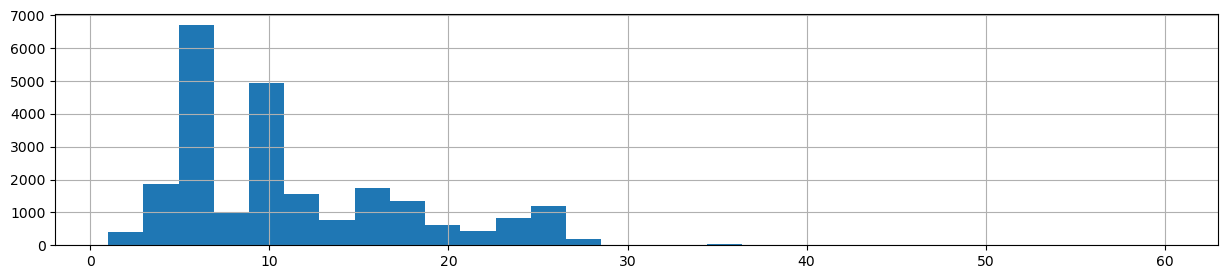

In [45]:
data.floors_total.hist(bins = 30, figsize = (15,3)); # общий график

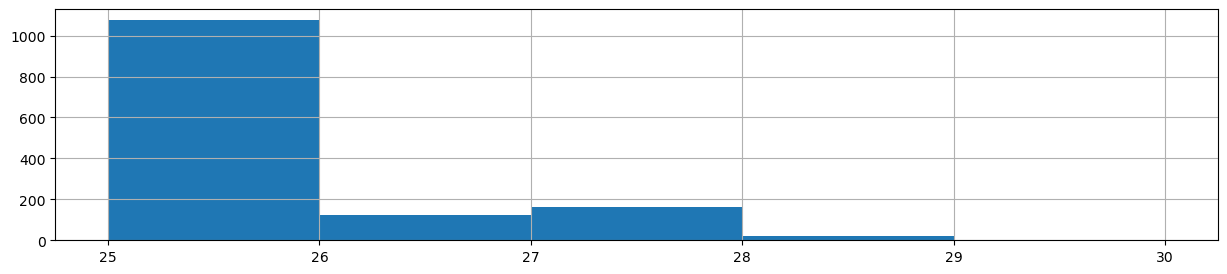

In [46]:
data.floors_total.hist(bins = 5, figsize = (15,3), range=(25,30)); # зум

Количество этажей 28 и более - редкости с большой долей уверенности.
Минимальное количество 1, поэтому минимальные значения не отсекаем.

Критерии отсечения 28 этажей попадает в диапазон между квантилями 0.0012, 0.01.

In [47]:
# замена выбросов на Nan
data['floors_total2'] = data['floors_total']
data.loc[data['floors_total2'] >= 28, 'floors_total2'] = data.loc[data['floors_total2']=='nan', 'floors_total2'] 

# проверка условия фильтрации значений - не более 1% данных от изначального объема
print(1-(data.floors_total2.count()/data.floors_total.count()))
print(data.floors_total.count()-data.floors_total2.count())

0.0022868758734595485
54


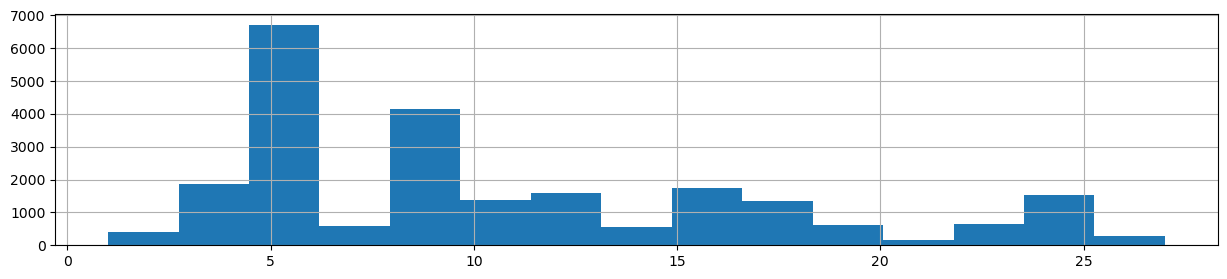

In [48]:
data.floors_total2.hist(bins = 15, figsize = (15,3)); # общий график после фильтрации

Резюме по устранению редких и выбивающихся значений параметра: суммарно удалено 54 значения, что составляет около 0.2% от исходных данных

###### 4.2.6 Жилая площадь

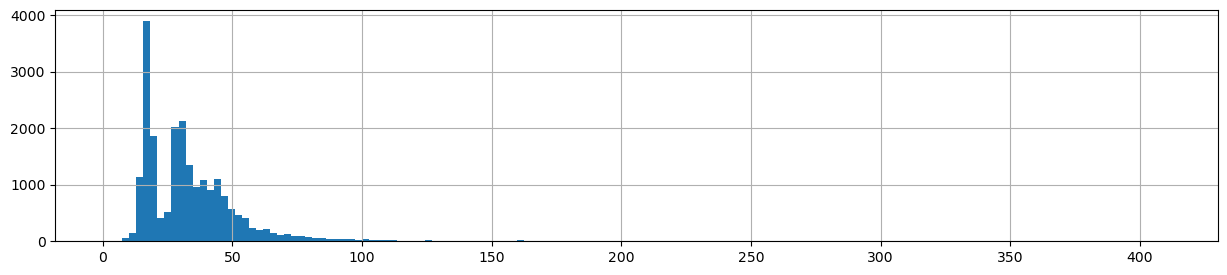

In [49]:
data.living_area.hist(bins = 150, figsize = (15,3)); # общий график не презентабелен

<AxesSubplot:>

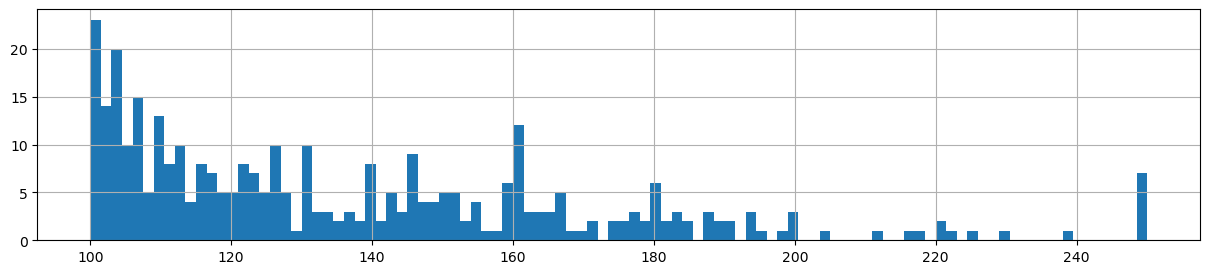

In [50]:
data.living_area.hist(bins = 100, figsize = (15,3), range = (100, 250)) # зум1 на крупных значениях

<AxesSubplot:>

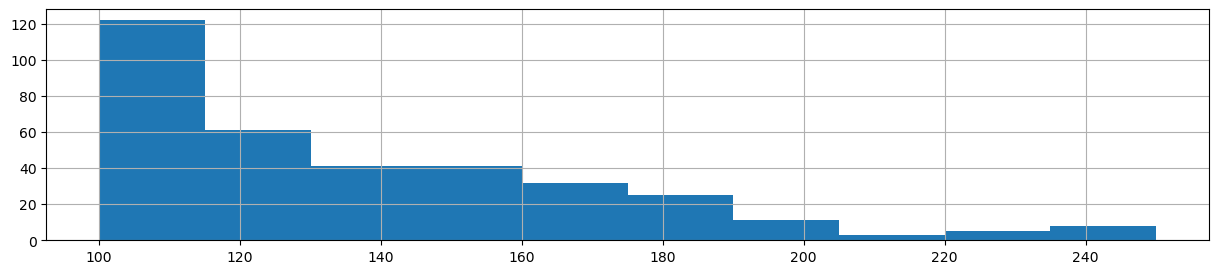

In [51]:
data.living_area.hist(bins = 10, figsize = (15,3), range = (100, 250)) # зум2 на крупных значениях

<AxesSubplot:>

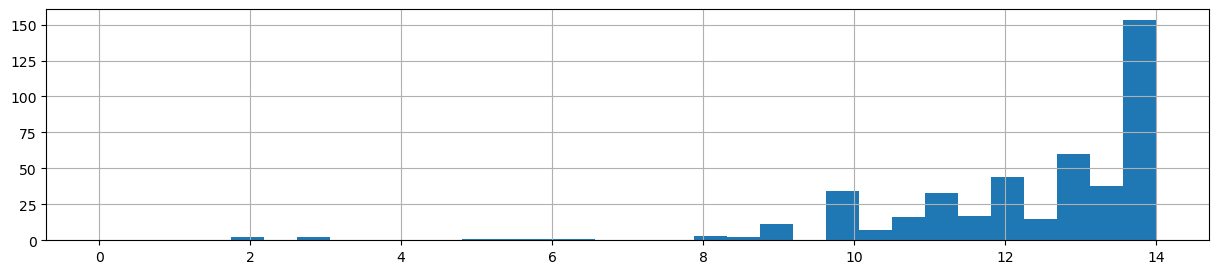

In [52]:
data.living_area.hist(bins = 32, figsize = (15,3), range = (0, 14)) # зум на мелких значениях

Согласно графикам выше в первой итерации очистки данных от выбросов были приняты критерии отсечения 130м и 11м.  

Каждый их этих критериев попадает диапазон между квантилями 0.0012, 0.01 и .99, .9988 соответственно. Но при такой фильтрации удаляется 1.6% данных.

Поэтому были подобраны менее жесткие фильтры - менее 11м2 и более 190м2.

In [53]:
# создание нового столбца и замена выбросов на Nan
data['living_area2'] = data['living_area']
data.loc[data['living_area2'] < 11, 'living_area2'] = data.loc[data['living_area2']=='nan', 'living_area2'] 
data.loc[data['living_area2'] > 190, 'living_area2'] = data.loc[data['living_area2']=='nan', 'living_area2'] 

# проверка условия фильтрации значений - не более 1% данных от изначального объема
print(1-(data.living_area2.count()/data.living_area.count()))
print(data.living_area.count()-data.living_area2.count())

0.005551477335290933
121


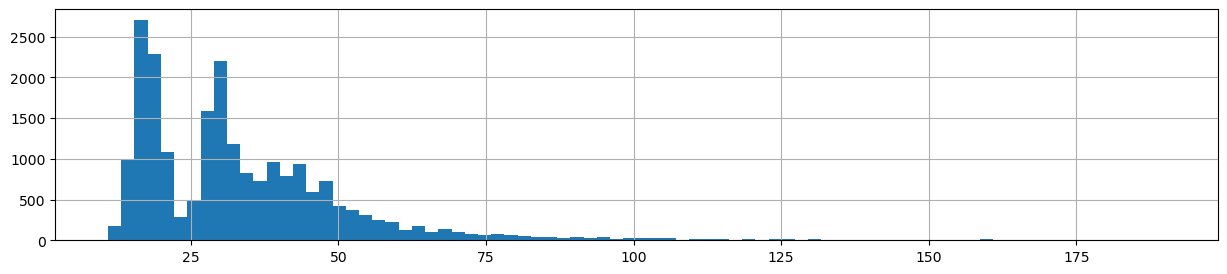

In [54]:
data.living_area2.hist(bins = 80, figsize = (15,3)); # общий график после фильтрации

Резюме по устранению редких и выбивающихся значений параметра: суммарно удалено 119 значения, что составляет чуть более 0.5% от исходных данных

###### 4.2.7 Этаж

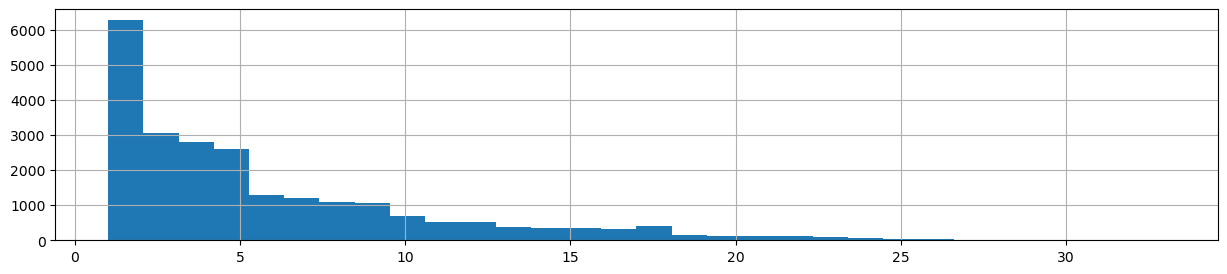

In [55]:
data.floor.hist(bins = 30, figsize = (15,3)); # общий график

In [56]:
data.floor.value_counts().to_frame()

,floor
2,3368
3,3073
1,2917
4,2804
5,2621
6,1305
7,1218
8,1083
9,1051
10,687


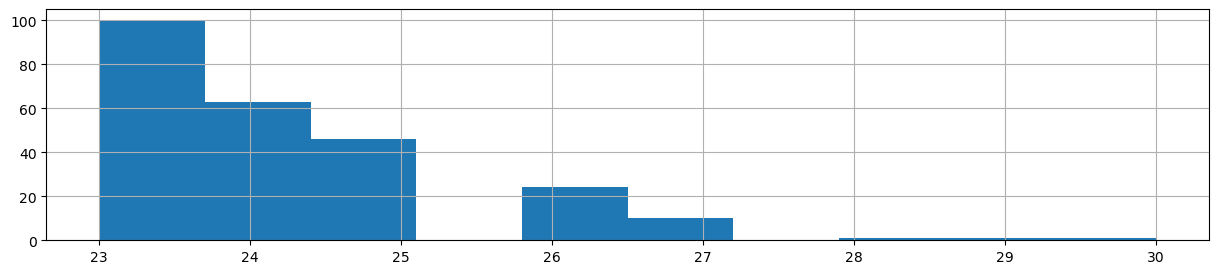

In [57]:
data.floor.hist(bins = 10, figsize = (15,3), range=(23,30)); # зум

Согласно графикам выше, принимаем, что квартиры на 27 этаже и выше - редкости с большой долей уверенности. Минимальное количество этажей 1, поэтому минимальные значения не отсекаем.

Критерии отсечения 27 этажей попадает в диапазон между квантилями 0.0012, 0.01.

In [58]:
# замена выбросов на Nan
data['floor2'] = data['floor']
data.loc[data['floor2'] > 25, 'floor2'] = data.loc[data['floor2']=='nan', 'floor2'] 

# проверка условия фильтрации значений - не более 1% данных от изначального объема
print(1-(data.floor2.count()/data.floor.count()))
print(data.floor.count()-data.floor2.count())

0.0016878349297438922
40


Резюме по устранению редких и выбивающихся значений параметра: суммарно удалено 40 значений, что составляет чуть более 0.1% от исходных данных

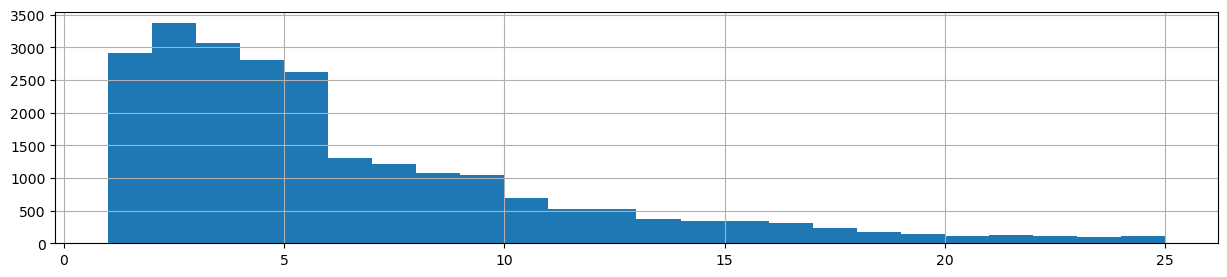

In [59]:
data.floor2.hist(bins = 24, figsize = (15,3)); # общий график после фильтрации

###### 4.2.8 Площадь кухни

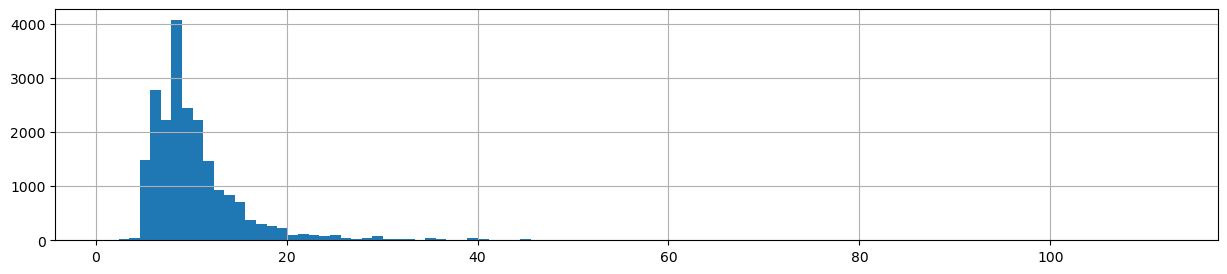

In [60]:
data.kitchen_area.hist(bins = 100, figsize = (15,3)); # общий график

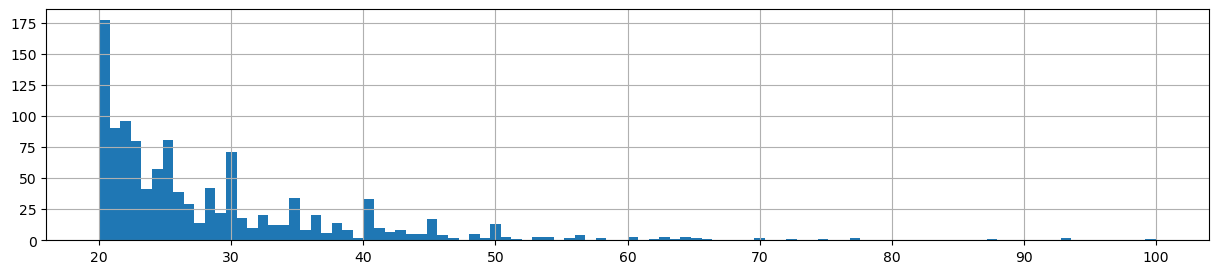

In [61]:
data.kitchen_area.hist(bins = 100, figsize = (15,3), range = (20,100)); # зум на крупных значениях

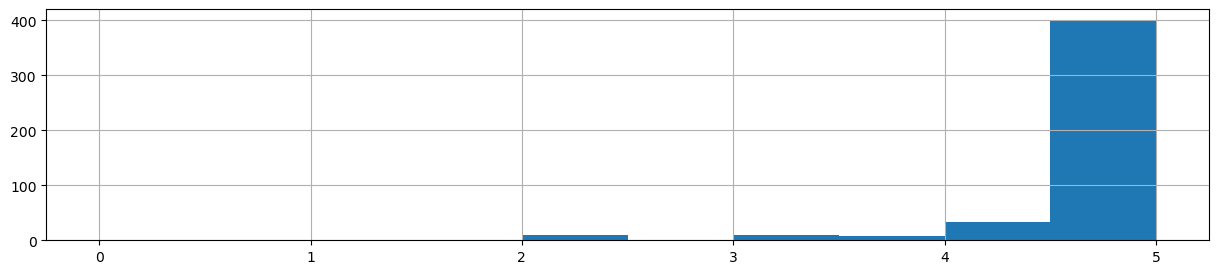

In [62]:
data.kitchen_area.hist(bins = 10, figsize = (15,3), range = (0,5)); # зум на мелких значениях

Площади менее 4м2 и более 50м2 с большой долей уверенности можно считать редкостями.

Данные критерии отсечения попадают в диапазон между квантилями 0.0012, 0.01 и .99, .9988 соответственно.

In [63]:
# создание нового столбца и замена выбросов на Nan
data['kitchen_area2'] = data['kitchen_area']
data.loc[data['kitchen_area2'] <= 4, 'kitchen_area2'] = data.loc[data['kitchen_area2']=='nan', 'kitchen_area2'] 
data.loc[data['kitchen_area2'] >= 50, 'kitchen_area2'] = data.loc[data['kitchen_area2']=='nan', 'kitchen_area2'] 

# проверка условия фильтрации значений - не более 1% данных от изначального объема
print(1-(data.kitchen_area2.count()/data.kitchen_area.count()))
print(data.kitchen_area.count()-data.kitchen_area2.count())

0.005228514074973156
112


Резюме по устранению редких и выбивающихся значений параметра: суммарно удалено 111 значений, что составляет около 0.5% от исходных данных

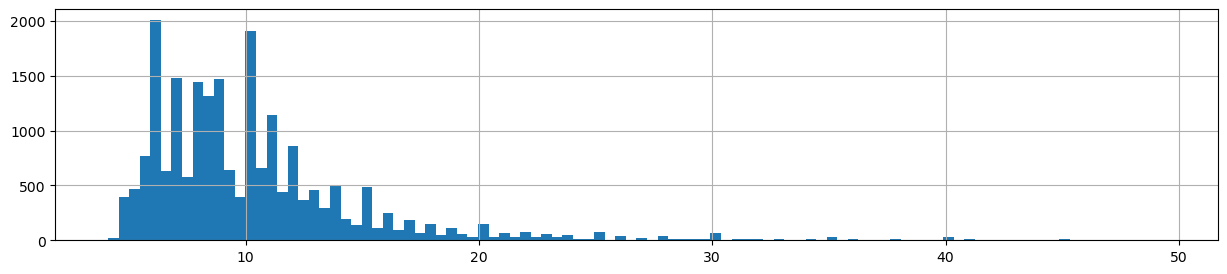

In [64]:
data.kitchen_area2.hist(bins = 100, figsize = (15,3)); # общий график после фильтрации

###### 4.2.9 Число балконов

In [65]:
data.balcony.value_counts().to_frame()

,balcony
0,15277
1,4195
2,3659
5,304
4,183
3,81


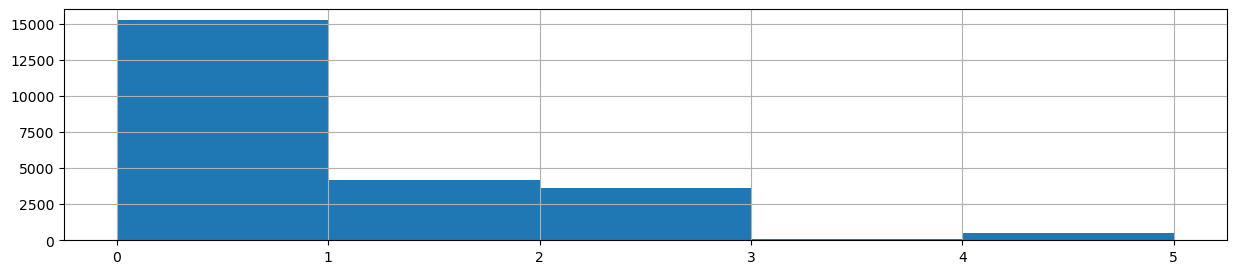

In [66]:
data.balcony.hist(bins = 5, figsize = (15,3)); # общий график

Число балконов более 2 - редкость, но при удалении значений 3, 4 и 5 балконов уходит порядка 568 значений или 2.4% от исходного количества балконов. Удалять значения не 2+, а 3+ так же не совсем корректно, т.к. согласно исходной информации 4 и 5 балконов встречаются чаще, чем 3 балкона. Таким образом, данный параметр оставляем без чистки.

###### 4.2.10 Сколько дней было размещено объявление

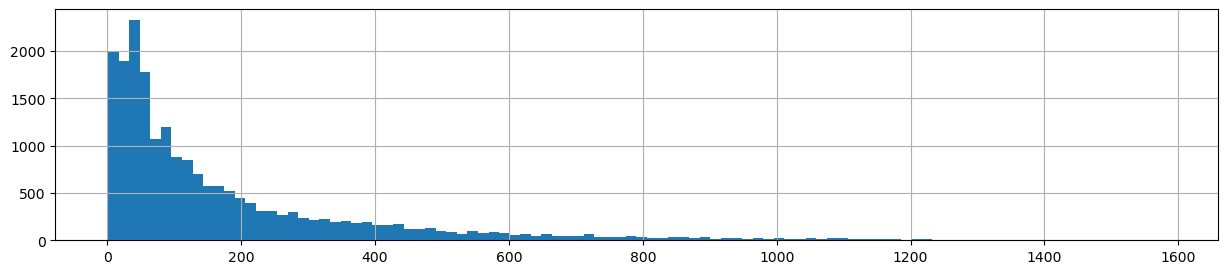

In [67]:
data.days_exposition.hist(bins = 100, figsize = (15,3)); # общий график

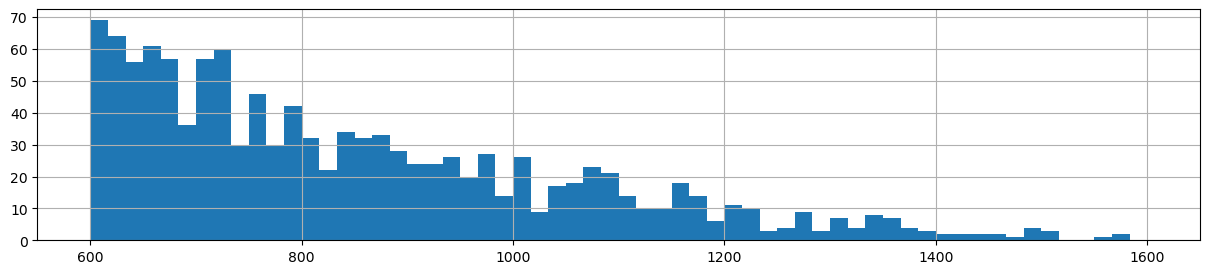

In [68]:
data.days_exposition.hist(bins = 60, figsize = (15,3), range = (600, 1600)); # зум на мелких значениях

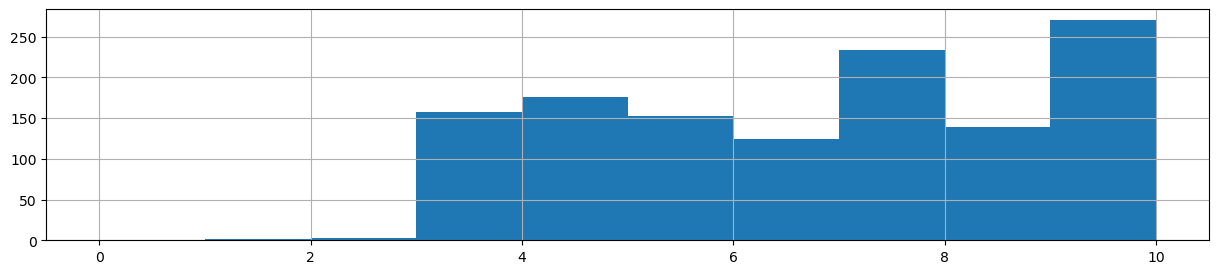

In [69]:
data.days_exposition.hist(bins = 10, figsize = (15,3), range = (0, 10)); # зум на мелких значениях

Длительность размещения объявление менее 3 дней и более 1200 - редкости.

Данные критерии отсечения попадают в диапазон между квантилями 0.0012, 0.01 и .99, .9988 соответственно.

In [70]:
# создание нового столбца и замена выбросов на Nan
data['days_exposition2'] = data['days_exposition']
data.loc[data['days_exposition2'] <= 3, 'days_exposition2'] = data.loc[data['days_exposition2']=='nan', 'days_exposition2'] 
data.loc[data['days_exposition2'] >= 1200, 'days_exposition2'] = data.loc[data['days_exposition2']=='nan', 'days_exposition2'] 

# проверка условия фильтрации значений - не более 1% данных от изначального объема
print(1-(data.days_exposition2.count()/data.days_exposition.count()))
print(data.days_exposition.count()-data.days_exposition2.count())

0.00467881859830388
96


Резюме по устранению редких и выбивающихся значений параметра: суммарно удалено 95 значений, что составляет около 0.4% от исходных данных

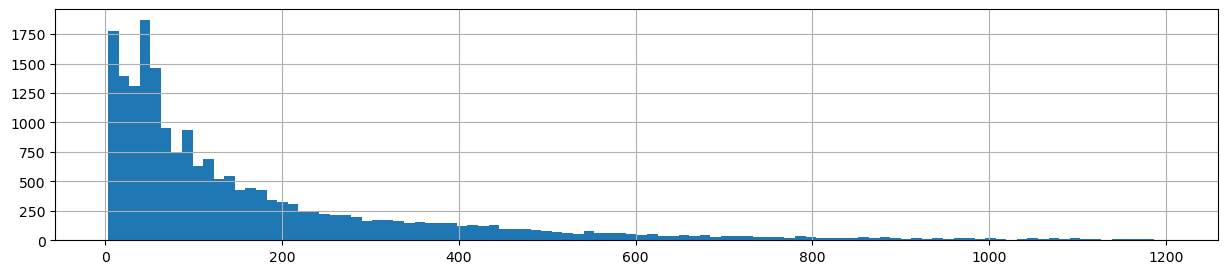

In [71]:
data.days_exposition2.hist(bins = 100, figsize = (15,3)); # общий график после фильтрации

##### 4.3 Итоги устранения редких и выбивающихся значений

Проведена работа с 9 пользовательскими числовыми параметрами, сделаем финальную проверку по изменению доли исходных данных

In [72]:
# датасет с общим кол-вом значений у пользовательских числовых параметров, с которыми проведена работа
(
    data[['billion_price', 'total_area2', 'rooms2','ceiling_height2','floors_total2','living_area2','floor2',
          'kitchen_area2','days_exposition2']]
    .apply (['count', 'min', 'max', 'median', 'mean'])     
    .style.format("{:,.2f}")
)


,billion_price,total_area2,rooms2,ceiling_height2,floors_total2,living_area2,floor2,kitchen_area2,days_exposition2
count,"23,491.00","23,548.00","23,668.00","14,433.00","23,559.00","21,675.00","23,659.00","21,309.00","20,422.00"
min,0.62,20.10,0.00,2.30,1.00,11.00,1.00,4.10,3.00
max,44.50,249.90,7.00,4.00,27.00,190.00,25.00,49.40,"1,199.00"
median,4.60,52.00,2.00,2.65,9.00,30.00,4.00,9.10,95.00
mean,5.95,59.02,2.06,2.72,10.62,34.16,5.86,10.45,175.76


In [73]:
numbers_after = (data[['billion_price', 'total_area2', 'rooms2','ceiling_height2','floors_total2','living_area2','floor2',
          'kitchen_area2','days_exposition2']].apply('count')).sum() 

numbers_before = (data[['last_price', 'total_area', 'rooms','ceiling_height','floors_total','living_area','floor',
                        'kitchen_area','days_exposition']].apply ('count')).sum()

round(100-(numbers_after/numbers_before)*100, 2)

0.45

Общая сумма всех удалений составляет менее 0.45%

In [74]:
# Показатели о кол-ве объявлений в датасете, минимальных и максимальных значениях 
# в выбранных параметрах о продаже квартир
# сырые данные

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max', 'median'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"23,699.00","23,699.00","14,504.00","20,518.00","23,699.00","21,796.00","21,421.00","23,699.00","23,613.00"
min,0.00,12.00,1.00,1.00,"12,190.00",2.00,1.30,1.00,1.00
max,19.00,900.00,100.00,"1,580.00","763,000,000.00",409.70,112.00,33.00,60.00
median,2.00,52.00,2.65,95.00,"4,650,000.00",30.00,9.10,4.00,9.00


### Добавление новых столбцов в таблицу для дальнейших исследований

In [75]:
data['price_per_sq.m'] = data['billion_price']/data['total_area2']          # цена одного квадратного метра
data['exposition_day'] = data['first_day_exposition'].dt.weekday            # день недели публикации объявления
data['exposition_month'] = data['first_day_exposition'].dt.month            # месяц публикации объявления
data['exposition_year'] = data['first_day_exposition'].dt.year              # год публикации объявления
data['cityCenters_nearest_km'] = round(data['cityCenters_nearest']/1000)    # расстояние до центра города в км (целые значения)

In [76]:
data = data.dropna(subset=['floors_total2'])
data['floors_total2'].isna().sum()

0

In [77]:
data['exposition_year'].info()

<class 'pandas.core.series.Series'>
Int64Index: 23559 entries, 0 to 23698
Series name: exposition_year
Non-Null Count  Dtype
--------------  -----
23559 non-null  int64
dtypes: int64(1)
memory usage: 368.1 KB


In [78]:
def floor_type_func(row):                                               # тип этажа квартиры
    floor = row['floor2']
    floors_total = row['floors_total2']
    if floor == 1:                                                        
        return 'первый'                                                
    elif floors_total == floor:
        return 'последний'
    return 'другой'
data['floor_type'] = data.apply(floor_type_func, axis = 1)

### Исследовательский анализ данных

#### Общая площадь

count    23409.000000
mean        59.012304
std         28.786860
min         20.100000
25%         40.000000
50%         52.000000
75%         69.000000
max        249.900000
Name: total_area2, dtype: float64

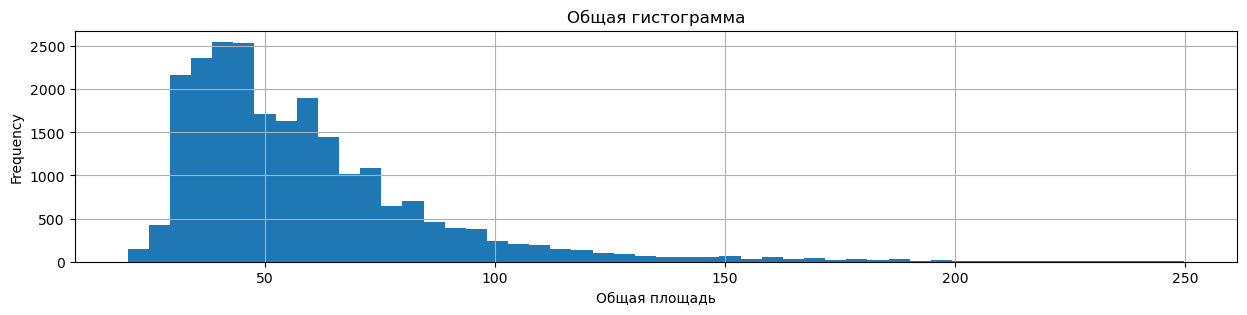

In [79]:
data['total_area2'].plot(kind ='hist', figsize = (15,3), bins = 50, grid = True, title = 'Общая гистограмма'); 
plt.xlabel('Общая площадь')
data['total_area2'].describe()


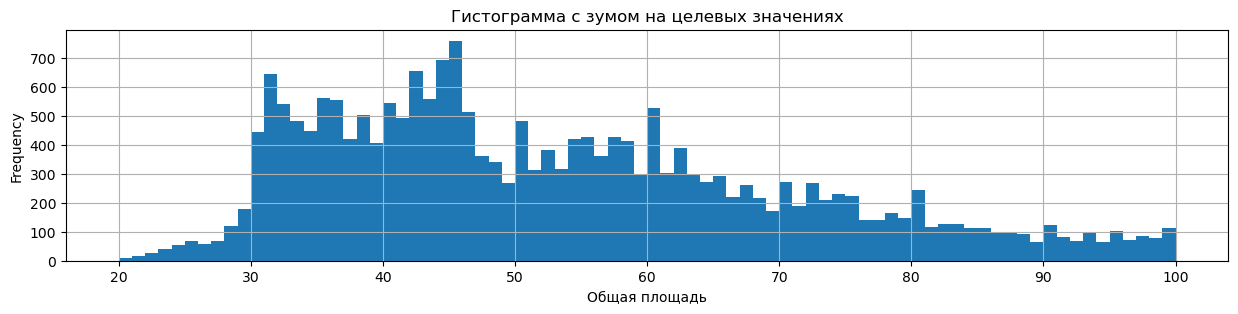

In [80]:
data['total_area2'].plot(kind ='hist', figsize = (15,3), bins = 80, range=(20,100),           # "зум" на целевых значениях 
                         grid = True, title = 'Гистограмма с зумом на целевых значениях'); 
plt.xlabel('Общая площадь');

Распределение значений общей площади не очень похоже на нормальное, особенностью является: 
* наличие 3 горбов на значениях ~30м2, ~45м2 и ~50-60м2. Гипотетически это может быть связано с историческим фактором, когда советское градостроительство было четко стандартизировано и каждому из этих пиков могут относится квартиры с одной, двумя и тремя комнатами соответственно, а флуктуации от этих значений - это до- и постсоветское строительство, а так же жилые объекты в сельских локациях; 
* "хвост" из больших и редко встречаемых значений, которые мы не стали отсекать, т.к. физическое существование единичных объектов недвижимости с площадью более 150м2 в Санкт-Петербурге и окрестностях вполне реалистично

   
Средняя общая площадь составляет 59м2, медиана 52м2. Различие обусловлено наличием в выборке больших значений, о которых говорилось выше.

Наибольшее количество объектов имеет площадь ~30-75м2. В данных так же имеется небольшая составляющая недвижимости с малой площадью (менее 30м2), что косвенно может быть связано с низкой долей квартир-студий и гостинок в представленных данных.


#### Жилая площадь

count    21573.000000
mean        34.171197
std         19.882184
min         11.000000
25%         18.700000
50%         30.000000
75%         42.300000
max        190.000000
Name: living_area2, dtype: float64

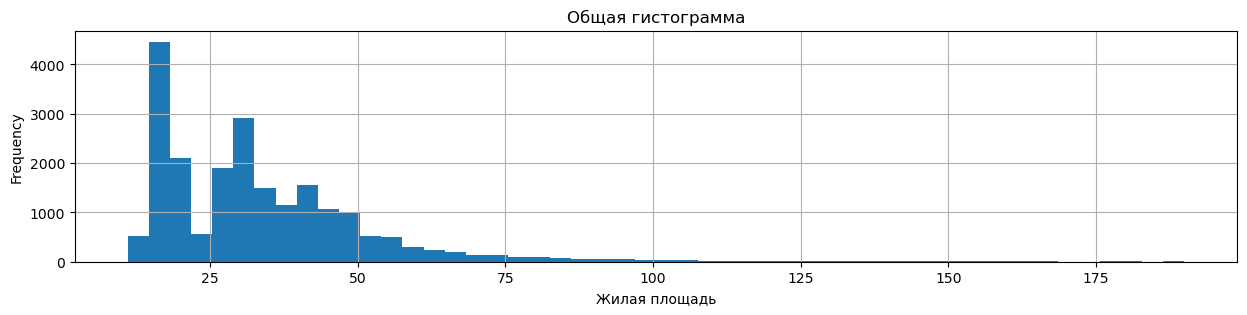

In [81]:
data['living_area2'].plot(kind ='hist', figsize = (15,3), bins = 50, grid = True, title = 'Общая гистограмма'); 
plt.xlabel('Жилая площадь')
data['living_area2'].describe()

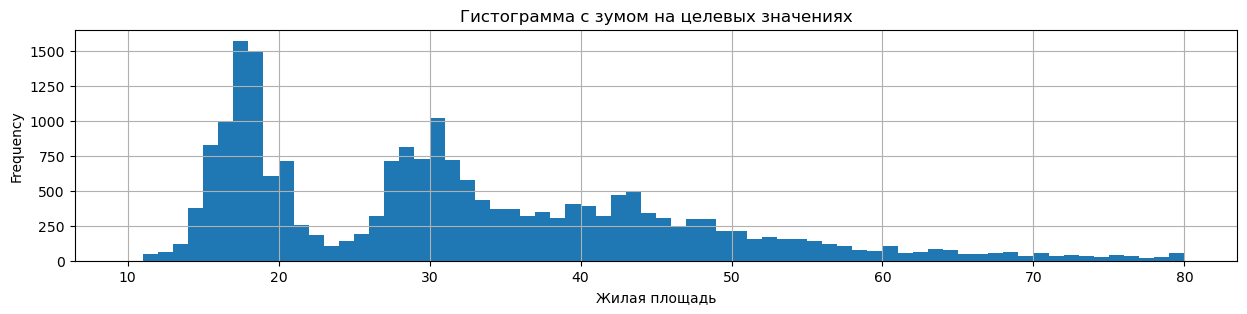

In [82]:
data['living_area2'].plot(kind ='hist', figsize = (15,3), bins = 70, range=(10,80),           # "зум" на целевых значениях 
                         grid = True, title = 'Гистограмма с зумом на целевых значениях'); 
plt.xlabel('Жилая площадь');

Распределение значений носит схожий характер с общей площадью: имеем три горба, которые вероятно соответствуют количеству комнат в объектах, а также имеем длинный хвост из высоких значений.

#### Площадь кухни

count    21221.000000
mean        10.432138
std          5.175315
min          4.100000
25%          7.000000
50%          9.100000
75%         12.000000
max         49.400000
Name: kitchen_area2, dtype: float64

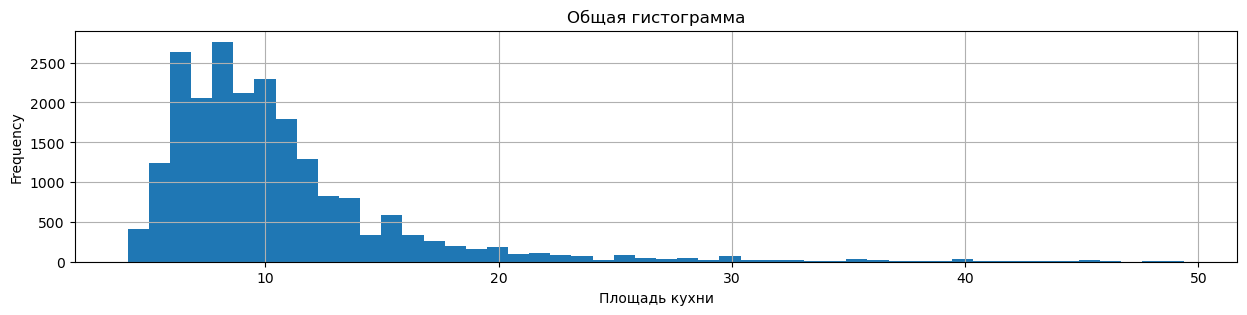

In [83]:
data['kitchen_area2'].plot(kind ='hist', figsize = (15,3), bins = 50, grid = True, title = 'Общая гистограмма'); 
plt.xlabel('Площадь кухни')
data['kitchen_area2'].describe()

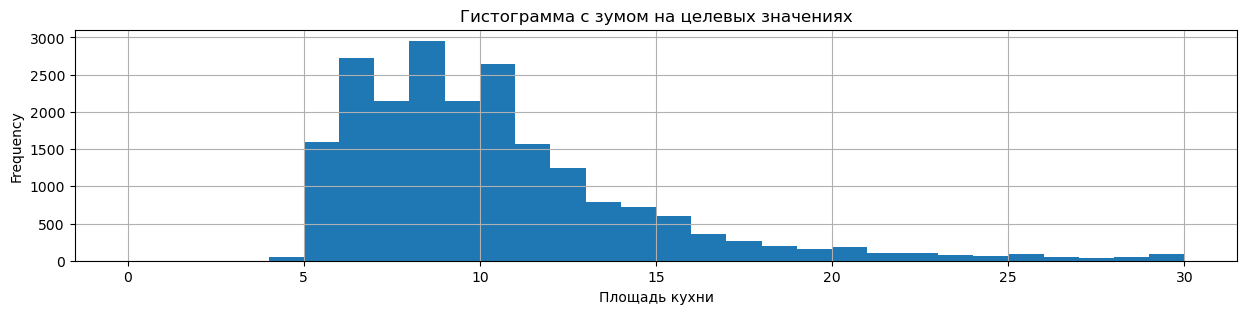

In [84]:
data['kitchen_area2'].plot(kind ='hist', figsize = (15,3), bins = 30, range=(0,30),           # "зум" на целевых значениях 
                         grid = True, title = 'Гистограмма с зумом на целевых значениях'); 
plt.xlabel('Площадь кухни');

В области целевых значений видим, что большее количество объектов имеет площадь кухни порядка 5-12м2, при этом 25% выборки имеют значения более 12м2, но встречаемость таких вариаций площади градационно уменьшаются до значений около 50м2.


#### Цена объекта

count    23351.000000
mean         5.946385
std          4.722464
min          0.620000
25%          3.400000
50%          4.600000
75%          6.700000
max         44.500000
Name: billion_price, dtype: float64

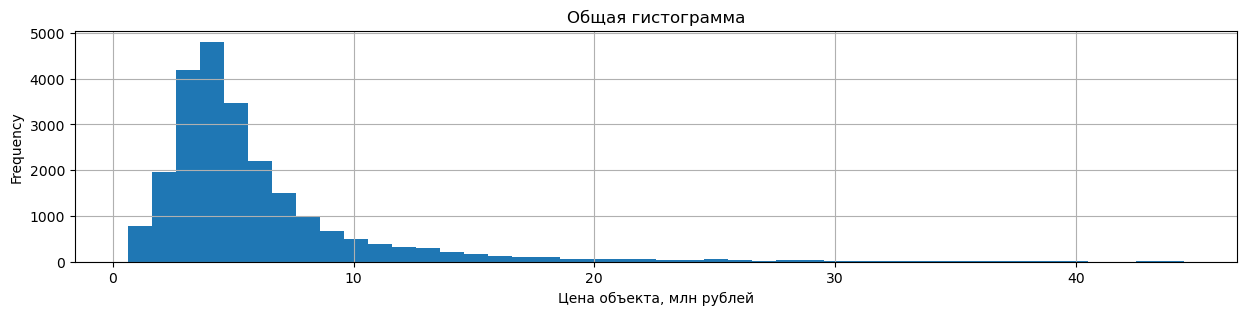

In [85]:
data['billion_price'].plot(kind ='hist', figsize = (15,3), bins = 44, grid = True, title = 'Общая гистограмма'); 
plt.xlabel('Цена объекта, млн рублей')
data['billion_price'].describe()

Гистограмма цен представлена нормальным распределением, медианная цена недвижимости - 4.6млн, средняя 5.94млн. 

Большая частота у цен из диапазона 3-7млн рублей. Так же имеется хвост из больших цен, но их частота крайне низка.


#### Количество комнат

count    23528.000000
mean         2.061374
std          1.035671
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          7.000000
Name: rooms2, dtype: float64

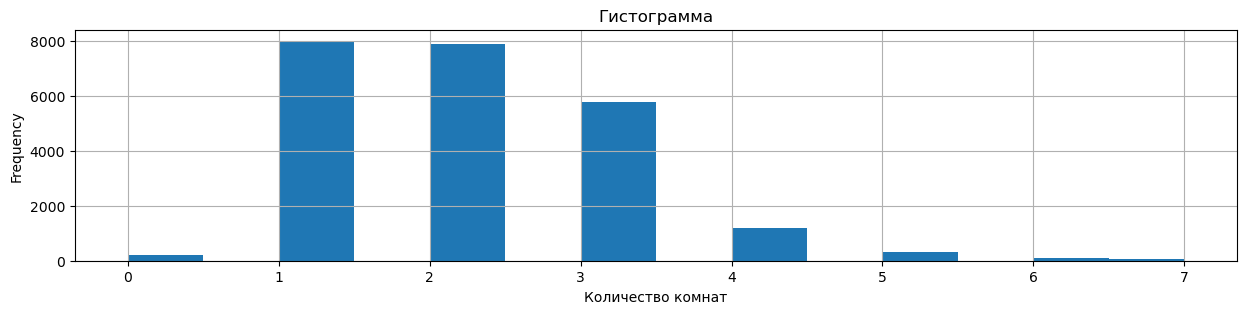

In [86]:
data['rooms2'].plot(kind='hist', bins = (14),figsize = (15,3), grid = True, 
                   xticks = (0,1,2,3,4,5,6,7), title = 'Гистограмма')

plt.xlabel('Количество комнат');
data['rooms2'].describe()

Преобладает количество 1-2-3 комнатных квартир, реже встречаются 4 и 5 комнатные, а так же квартиры с 0 комнатами, которые могут являться квартирами-студиями. Среднее и медиана схожи - 2 комнаты. Большекомнатные объекты встречаются редко.

#### Высота потолков

count    14401.000000
mean         2.721600
std          0.257576
min          2.300000
25%          2.510000
50%          2.650000
75%          2.800000
max          4.000000
Name: ceiling_height2, dtype: float64

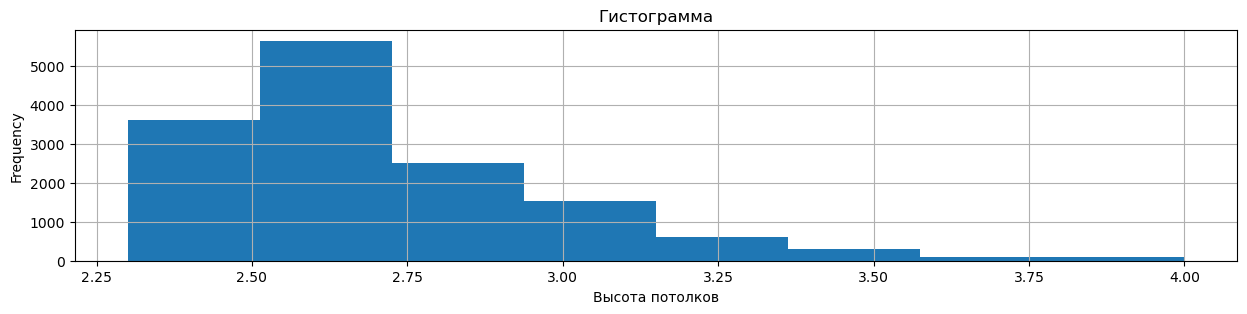

In [87]:
data['ceiling_height2'].plot(kind='hist', bins = 8, range = (2.3,4), figsize = (15,3), grid = True, title = 'Гистограмма')

plt.xlabel('Высота потолков');
data['ceiling_height2'].describe()

Распределение высот потолков неравномерно, наибольшее встречаемость у стандартных потолков в 2.3-2.7м, потолки выше 3м уже редкость

#### Этаж квартиры

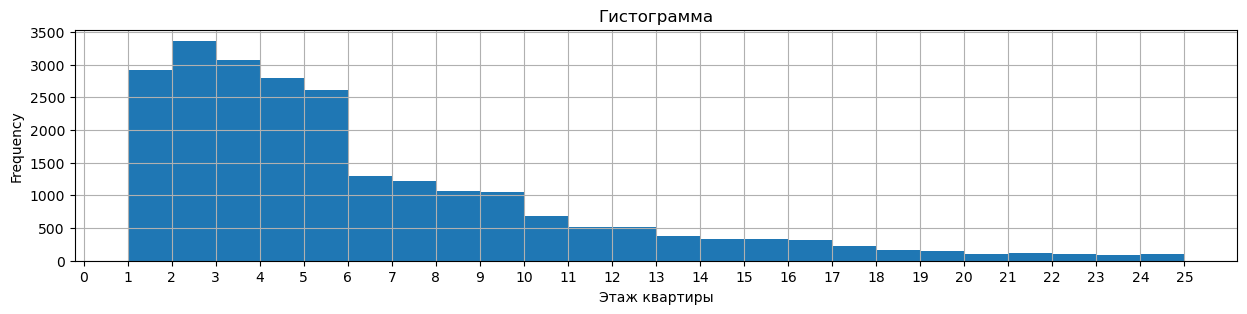

In [88]:
data['floor2'].plot(kind='hist', bins = (24),figsize = (15,3), grid =True, title = 'Гистограмма',
                   xticks = (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25))
plt.xlabel('Этаж квартиры');

Распределение этажей в выборке продаваемой недвижимости можно разделить на 3 блока:


* самый крупный, 1-5 этаж, здесь количество представлений каждого из этажей приблизительно одинаково, с небольшим отрывом у 2го этажа. Вероятно, большая часть недвижимости, попавшей сюда - классические 5тиэтажки-хрущевки, а так же первые пять этажей более высоких зданий
* средний блок, где встречаются этажи с 6-9 - классические 9тиэтажки и эти этажи у более высоких зданий
* остальная выборка - современная застройка с самыми высокими объектами

#### Тип этажа квартиры («первый», «последний», «другой»)

другой       17323
последний     3322
первый        2914
Name: floor_type, dtype: int64

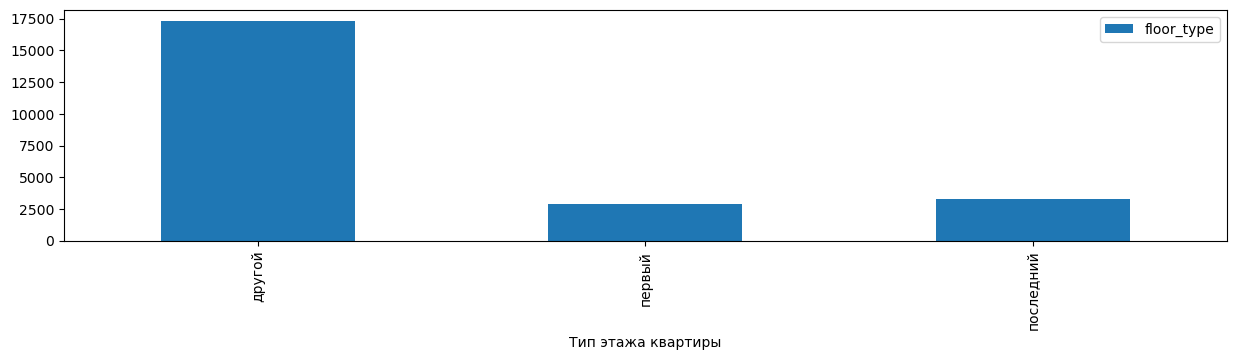

In [89]:
data.groupby('floor_type').agg({'floor_type':'count'}).plot(kind='bar', figsize = (15,3))
data.groupby('floor_type').agg({'floor_type':'count'})
plt.xlabel('Тип этажа квартиры');

data.floor_type.value_counts()

Количество первых и последних этажей почти одинаково примерно по 13%, большая часть данных представлена категорией "другой", около 74%. Такое распределение вполне ожидаемо, т.к. физически количество первых и последних этажей меньше, чем количество остальных.

***Общее количество этажей в доме***

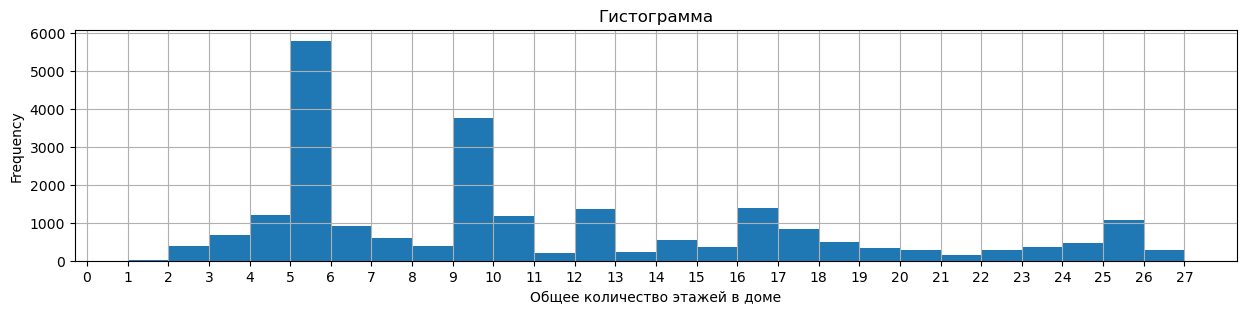

In [90]:
data['floors_total2'].plot(kind='hist', bins = (26),figsize = (15,3), grid =True, title = 'Гистограмма',
                   xticks = (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27))
plt.xlabel('Общее количество этажей в доме');

Среди общего количества этажей в домах преобладает 5, так же выделяются 9 этажки.  

Можно отметить, что среди зданий выше 9 этажей выделяются здания с количеством этажей 12, 16 и 25 - вероятно, это наиболее распространенный тип современной застройки.

#### Расстояние до центра города в метрах


count    18054.000000
mean     14169.302869
std       8616.318263
min        181.000000
25%       9217.750000
50%      13073.000000
75%      16267.750000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

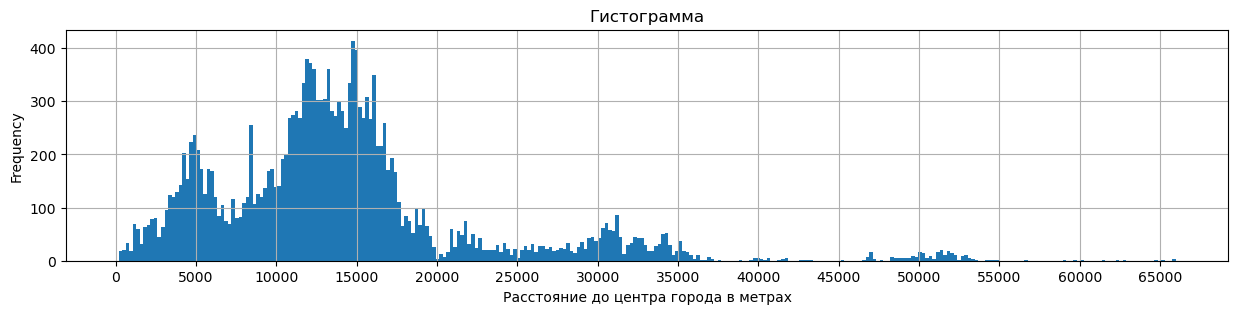

In [91]:
data['cityCenters_nearest'].plot(kind='hist', bins = (300),figsize = (15,3), grid = True, title = 'Гистограмма',
                                xticks = (0,5000,10000,15000,20000,25000,30000,35000,40000,45000,50000,55000,60000,65000))
plt.xlabel('Расстояние до центра города в метрах');
data['cityCenters_nearest'].describe()

Большая часть объектов недвижимости находится в примерно в 10-16км от центра города, вероятно это среднее расстояние от большинства спальных районов Санкт-Петербурга и пригородов. Так же есть небольшой пик в районе 5км, вероятно это либо дома старого жилого фонда, либо небольшие новые застройки недалеко от центра.

Ближайший к центру объект находится всего в 180м от географического центра Петербурга. Так же можно отметить, что в выборке есть объекты, которые находятся на расстоянии до 66км от центра Санкт-Петербурга.

#### Расстояние до ближайшего аэропорта

count    18031.000000
mean     28794.908935
std      12619.979434
min          0.000000
25%      18557.000000
50%      26757.000000
75%      37244.000000
max      84869.000000
Name: airports_nearest, dtype: float64

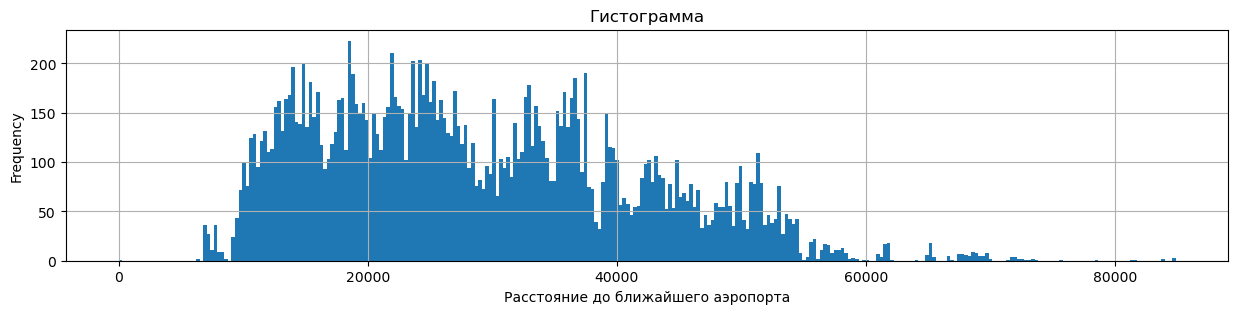

In [92]:
data['airports_nearest'].plot(kind='hist', bins = (300),figsize = (15,3), grid = True, title = 'Гистограмма')
plt.xlabel('Расстояние до ближайшего аэропорта');
data['airports_nearest'].describe()

Расстояние от центра Петербурга до аэропорта Пулково - 21км, что в целом подтверждается гистограммой выше.

Флуктуации левее этого значения показывают близость к Пулково, где самое минимальное значение - 0км, объект недвижимости находится в самом Пулково.

#### Расстояние до ближайшего парка

count    8038.000000
mean      490.506594
std       341.459510
min         1.000000
25%       288.000000
50%       455.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

8038

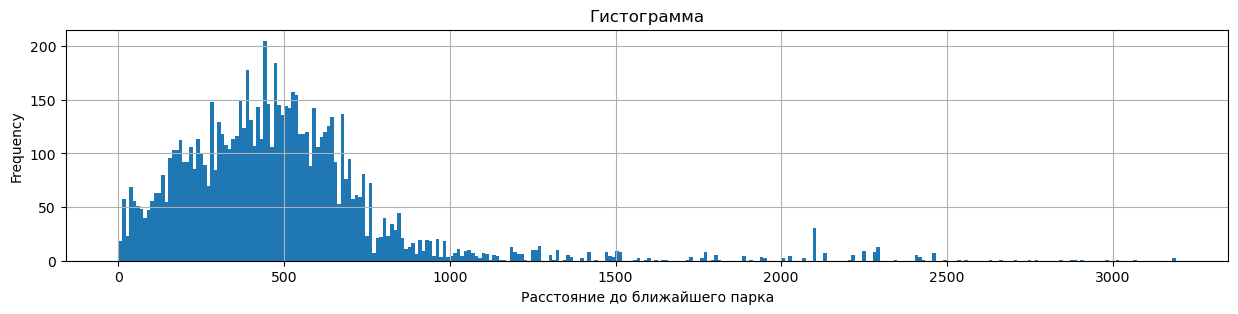

In [93]:
data['parks_nearest'].plot(kind='hist', bins = (300),figsize = (15,3), grid = True, title = 'Гистограмма')
plt.xlabel('Расстояние до ближайшего парка');

display(data['parks_nearest'].describe())
data['parks_nearest'].count()

Из чуть более 8 тысяч точек, имеющих информацию о близости парка, средним расстоянием является 490м, около 500 объектов находятся очень близко к паркам (0-100м).

Т.к. данные есть только по трети всех объектов, сделать корректные выводы затруднительно. Добавив оставшиеся данные, картина может поменяться значительно, например, если предположить, что пропуски у остальных двух третьих связаны с отсутствием парков рядом вообще.

#### День и месяц публикации объявления

count    23559.000000
mean         2.568021
std          1.788797
min          0.000000
25%          1.000000
50%          3.000000
75%          4.000000
max          6.000000
Name: exposition_day, dtype: float64

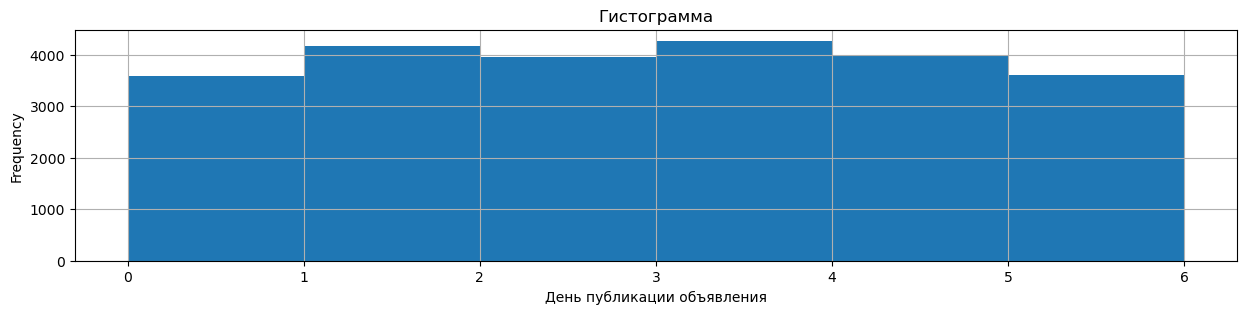

In [94]:
data['exposition_day'].plot(kind='hist', bins = (6),figsize = (15,3), grid = True, title = 'Гистограмма')
plt.xlabel('День публикации объявления');
data['exposition_day'].describe()

count    23559.000000
mean         6.399380
std          3.493236
min          1.000000
25%          3.000000
50%          6.000000
75%         10.000000
max         12.000000
Name: exposition_month, dtype: float64

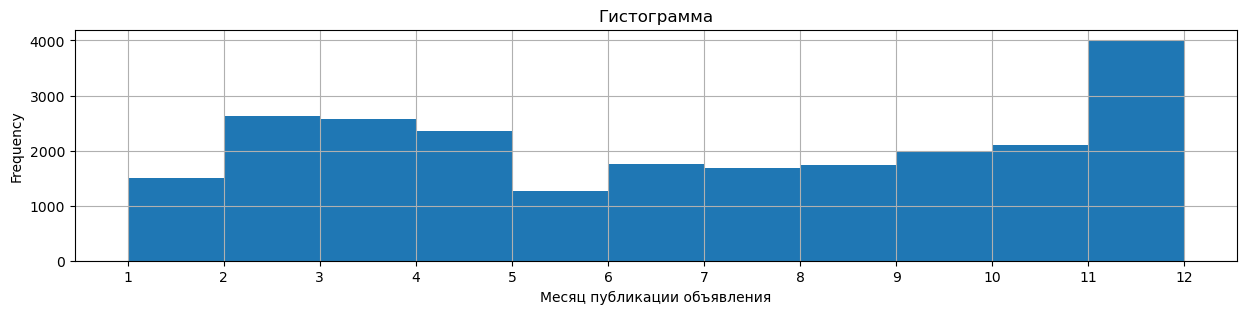

In [95]:
data['exposition_month'].plot(kind='hist', bins = (11),figsize = (15,3), grid = True, title = 'Гистограмма',
                              xticks = (1,2,3,4,5,6,7,8,9,10,11,12))
plt.xlabel('Месяц публикации объявления');
data['exposition_month'].describe()

Публикуют объявления преимущественно в будние дни, наименьшее количество публикаций в мае и январе. 

Наибольшее в феврале-марте. 

Можно предположить, что люди реже занимаются вопросами с недвижимостью в месяцы, когда есть большое количество выходных дней (новогодние и майские праздники), в другие месяцы публикации делают в основном так же не в выходные. Гипотеза - база наполняется в рабочее время сотрудников сервиса Яндекс Недвижимость.

***Как быстро продавались квартиры?***

count    20303.000000
mean       175.767227
std        206.229287
min          3.000000
25%         45.000000
50%         95.000000
75%        228.000000
max       1199.000000
Name: days_exposition2, dtype: float64

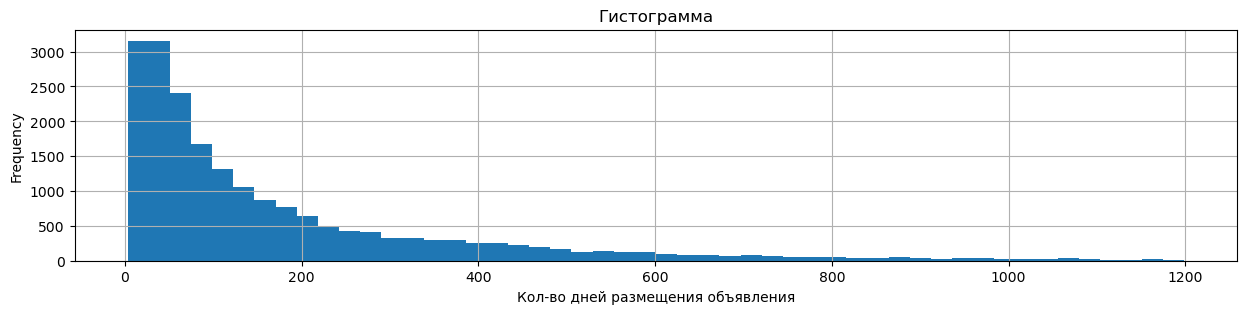

In [96]:
data['days_exposition2'].plot(kind='hist', bins = (50),figsize = (15,3), grid = True, title = 'Гистограмма')
plt.xlabel('Кол-во дней размещения объявления');
data['days_exposition2'].describe()

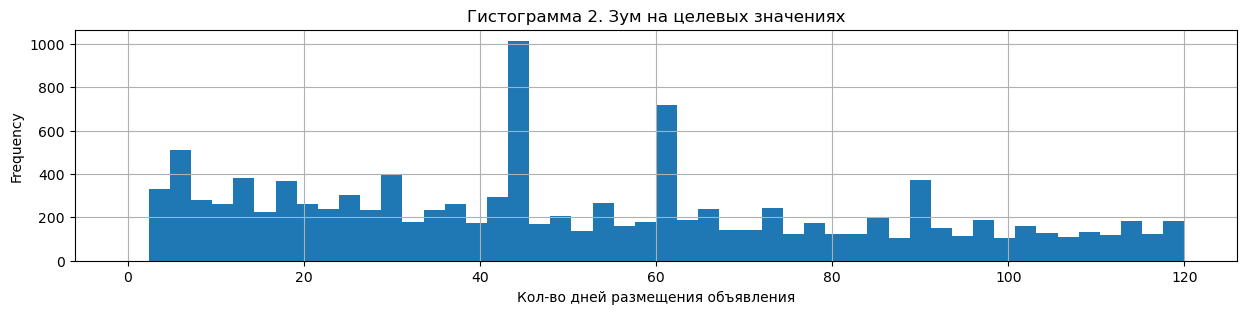

In [97]:
data['days_exposition2'].plot(kind='hist', bins = (50), figsize = (15,3), grid = True, 
                              range = (0,120), title = 'Гистограмма 2. Зум на целевых значениях');

plt.xlabel('Кол-во дней размещения объявления');

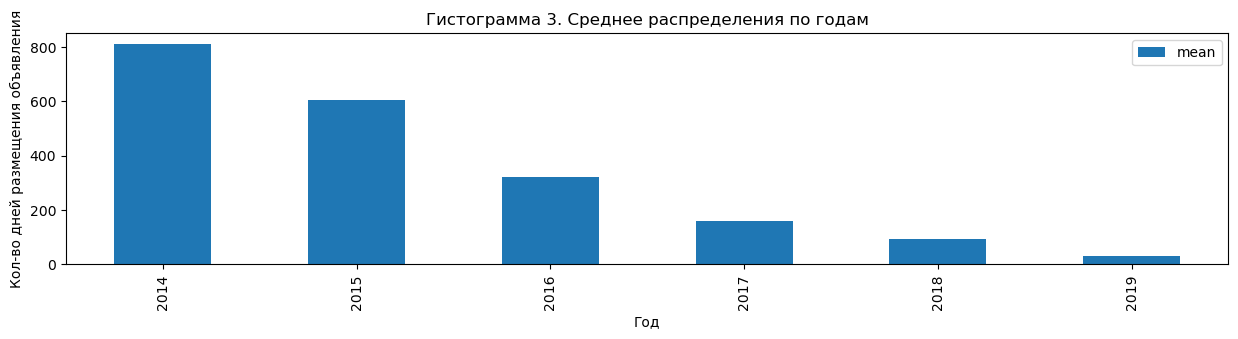

In [98]:
# зависимость скорости продажи от даты размещения (год)
data.pivot_table(index = 'exposition_year', values = 'days_exposition2', aggfunc = {'mean'}).plot(
                 kind = 'bar', figsize = (15,3), title = 'Гистограмма 3. Среднее распределения по годам')
plt.xlabel('Год');
plt.ylabel('Кол-во дней размещения объявления');

Верхняя гистограмма представлена распределением Пуассона, медиана равна 95 дней, среднее значение из-за влияния очень долгих продаж составляет 175 дней. 

На второй гистограмме с зумом на целевых значениях наибольшее встречаемость отмечается у мод 45, 60 и 90 днях. Это связано с особенностями работы сервиса: эти даты регламентируют срок бесплатного размещения объявления, после которого истечения которого клиенты возможно решают не продлевать срок действия на платной основе. При исключении пиков на гистограмме 2 можно отметить градационное снижение скорости продаж. 

На гистограмме 3 отмечается сокращение количества дней размещения объявления - что очевидно, т.к. чем раньше было опубликовано объявление, тем дольше у него физическая возможность "наращивать" данную метрику. 

Ориентируясь на 25-тый и 75-тый квантили, как на маркеры быстрых и долгих продаж, можно заключить, что до 1.5мес - продажа быстрая, более 7.5мес - долгая.

***Факторы, влияющие на общую (полную) стоимость объекта***

0.7833860005888886

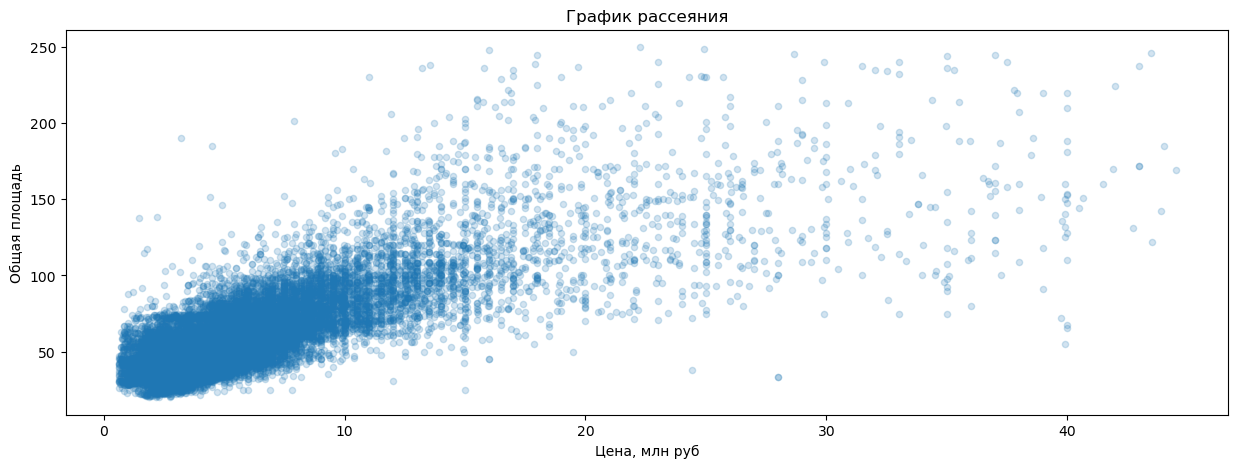

In [99]:
# зависимость цены от общей площади
data.plot(kind='scatter', x='billion_price', y = 'total_area2', alpha=0.2, figsize = (15,5), 
          title = 'График рассеяния')
plt.xlabel('Цена, млн руб')
plt.ylabel('Общая площадь')

data['billion_price'].corr(data['total_area2']) # определим коэффициент корреляции

Коэффициент корреляции показывает, что с увеличением общей площади растет и цена объекта. Вероятно, коэффициент корреляции был значительно ближе к 1, если мы имели более однородную выборку по населенным пунктам или районам. Так, например, квартира в Санкт-Петербурге площадью 100м2 может стоить значительно дороже объекта с такой же площадью, но в 40км от центра Петербурга.

0.6904643105317644

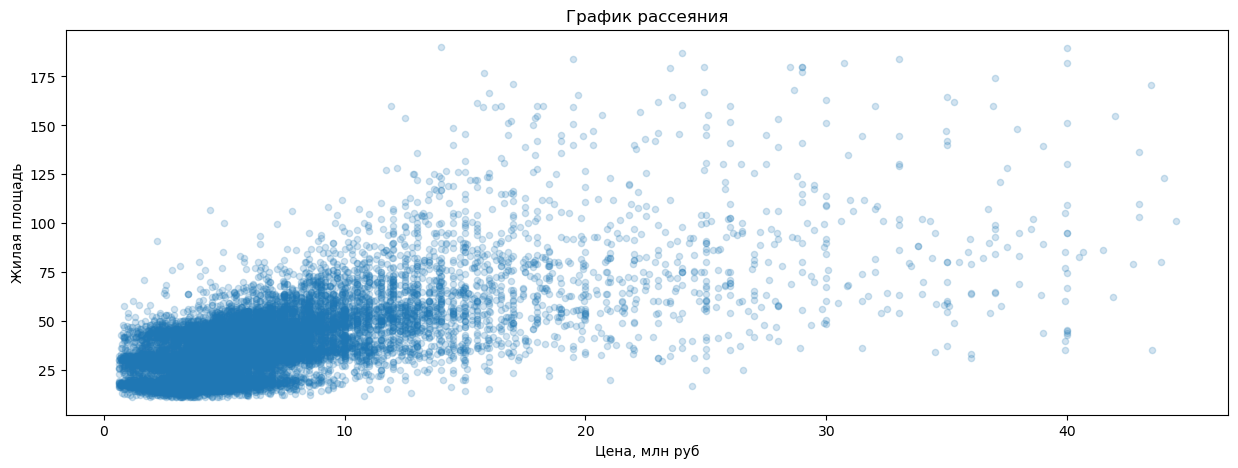

In [100]:
# зависимость цены от жилой площади
data.plot(kind='scatter', x='billion_price', y = 'living_area2', alpha=0.2, figsize = (15,5), 
          title = 'График рассеяния')
plt.xlabel('Цена, млн руб')
plt.ylabel('Жилая площадь')

data['billion_price'].corr(data['living_area2']) # определим коэффициент корреляции

Видим схожую картину с общей площадью, что предсказуемо, т.к. жилая площадь напрямую зависит от общей. Больше жилая площадь - больше цена. Возможно было бы интересно изучить данную зависимость отдельно для разных групп общей площади и заметить более тонкие закономерности.


0.6022743885811315

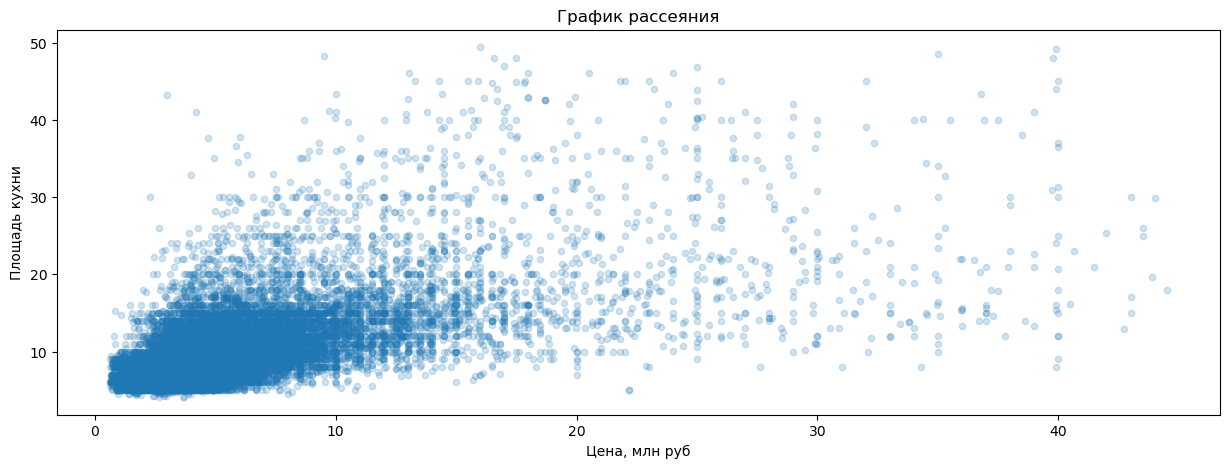

In [101]:
# зависимость цены от площади кухни
data.plot(kind='scatter', x='billion_price', y = 'kitchen_area2', alpha=0.2, figsize = (15,5), 
          title = 'График рассеяния')
plt.xlabel('Цена, млн руб')
plt.ylabel('Площадь кухни')

data['billion_price'].corr(data['kitchen_area2']) # определим коэффициент корреляции

Все аналогично предыдущим двум графикам, при этом коэффициент корреляции снова уменьшился. 

Такое постепенное снижение r может обозначать уменьшение влияния цены на анализируемые доли от общей площади (жилая, кухня), т.к. начинают оказывать влияние и другие факторы, например, геолокация или качество самого жилья.

0.5040139758943047

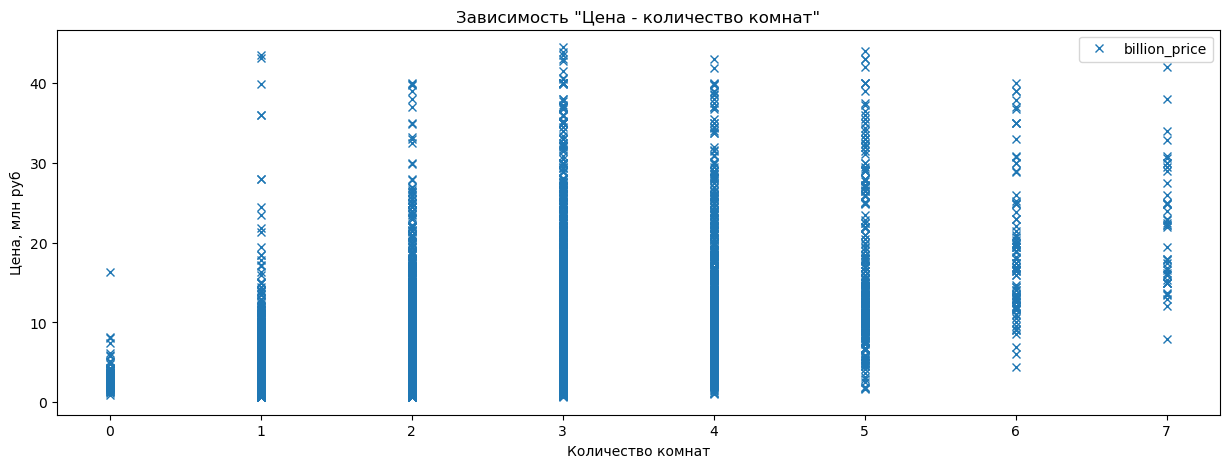

In [102]:
# зависимость цены от количества комнат
data.plot(x = 'rooms2', y='billion_price', style='x', figsize = (15,5), title = 'Зависимость "Цена - количество комнат"')
plt.ylabel('Цена, млн руб')
plt.xlabel('Количество комнат')

data['billion_price'].corr(data['rooms2']) # определим коэффициент корреляции

Ожидаемо увидеть здесь зависимость увеличения цены при большем количестве комнат. 

При этом, мы видим, что высокая цена есть и у квартир с малым количеством комнат.

Вероятно, низкая корреляция обусловлена влиянием других факторов. При группировке объектов по разным параметрам возможно будет увидеть данную зависимость ярче или же наоборот слабее. 

,count,mean,median
floor_type,,,
другой,17197,6.183514,4.8
первый,2888,4.652863,3.9
последний,3266,5.841604,4.3


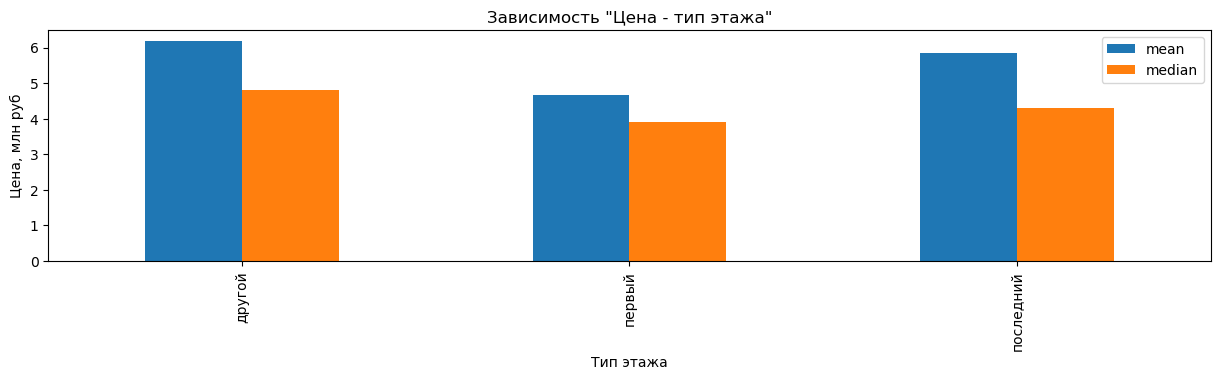

In [103]:
# зависимость цены от этажа, на котором расположена квартира (первый, последний, другой)
data.pivot_table(index = 'floor_type', values =  'billion_price', aggfunc = {'mean', 'median'}).plot(
                 kind = 'bar', figsize = (15,3), title = 'Зависимость "Цена - тип этажа"')
plt.xlabel('Тип этажа')
plt.ylabel('Цена, млн руб')
data.pivot_table(index = 'floor_type', values =  'billion_price', aggfunc = {'mean', 'median', 'count'})

Медианное и среднее значение показывают, что прослеживается следующая зависимость цены от типа этажа: первый этаж традиционно объясняется меньшей привлекательностью из-за целого ряда причин (сыро и влажно, прохожие, отсутствие балкона, живность, мало света, шумно и прочее), последний - протекает крыша, плохая термоизоляция. Для категории "другие" данные факторы имеют меньшее значение.

,mean,median
exposition_day,,
0,5.97,4.63
1,5.89,4.70
2,6.06,4.70
3,6.15,4.60
4,5.80,4.55
5,5.72,4.50
6,5.83,4.50


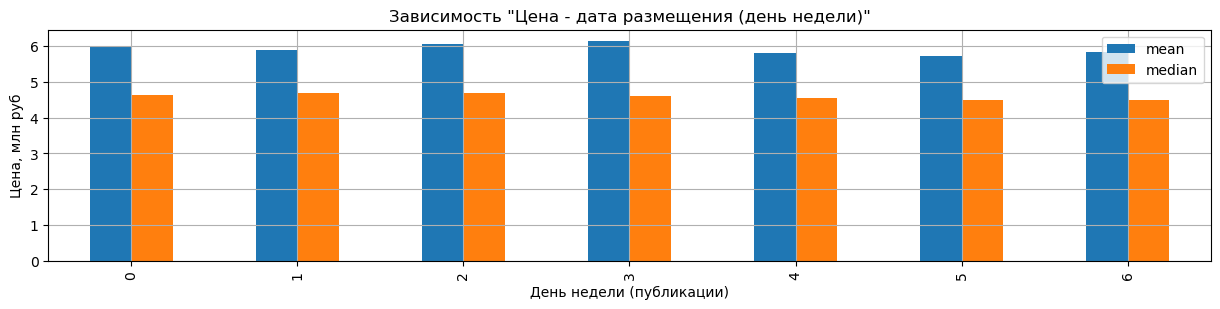

In [104]:
# зависимость цены от даты размещения (день недели)
data.pivot_table(index = 'exposition_day', values =  'billion_price', 
                 aggfunc = {'mean', 'median'}).plot(kind = 'bar', figsize = (15,3), grid = True, 
                                                    title = 'Зависимость "Цена - дата размещения (день недели)"')

plt.xlabel('День недели (публикации)')
plt.ylabel('Цена, млн руб')

data.pivot_table(index = 'exposition_day', values =  'billion_price', 
                 aggfunc = {'mean', 'median'}).style.format("{:,.2f}")

Зависимость "стоимость объекта недвижимости - день недели" - отсутствует. И для средних, и для медианных значений цены.

,mean,median
exposition_month,,
1,6.05,4.60
2,5.94,4.65
3,5.89,4.64
4,5.93,4.78
5,5.96,4.50
6,5.78,4.40
7,5.91,4.60
8,5.98,4.56
9,6.03,4.69


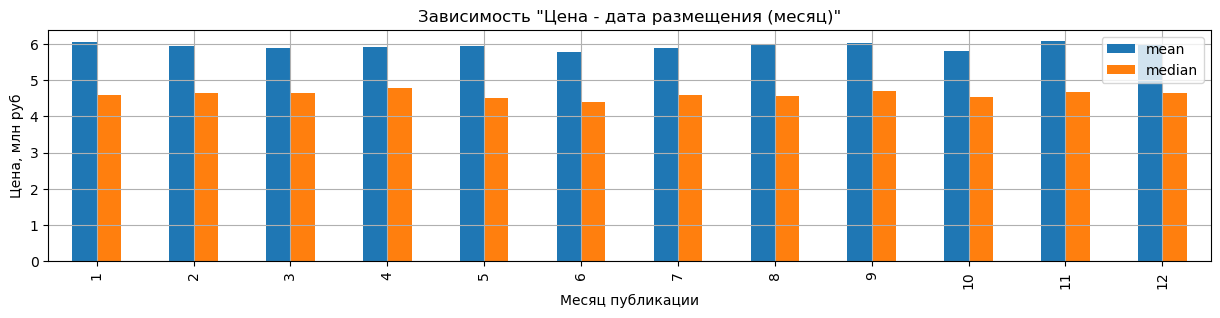

In [105]:
# зависимость цены от даты размещения (месяц) exposition_month
data.pivot_table(index = 'exposition_month', values =  'billion_price', 
                 aggfunc = {'mean', 'median'}).plot(kind = 'bar', figsize = (15,3), grid = True,
                                                   title = 'Зависимость "Цена - дата размещения (месяц)"')

plt.xlabel('Месяц публикации')
plt.ylabel('Цена, млн руб')

data.pivot_table(index = 'exposition_month', values =  'billion_price', 
                 aggfunc = {'mean', 'median'}).style.format("{:,.2f}")

Месяца так же не дают каких-либо закономерностей, связанных с ценой квартир. 

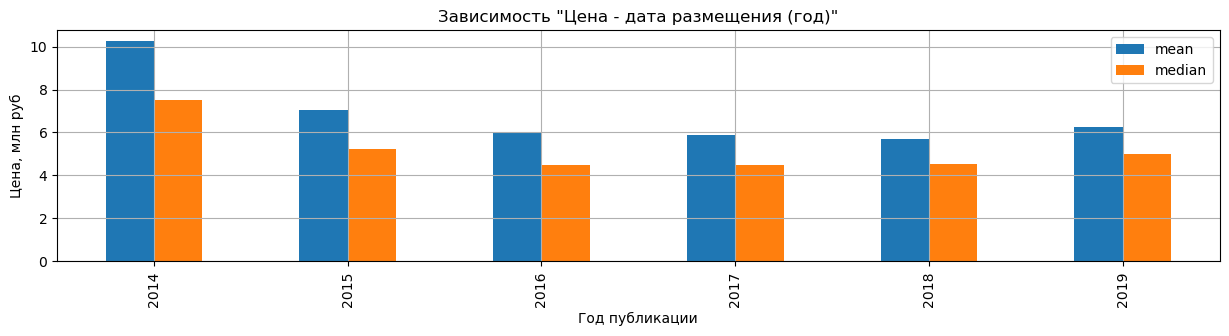

In [106]:
# зависимость цены от даты размещения (год)
data.pivot_table(index = 'exposition_year', values =  'billion_price', 
                 aggfunc = {'mean', 'median'}).plot(kind = 'bar', figsize = (15,3), grid = True, 
                                                    title = 'Зависимость "Цена - дата размещения (год)"')

plt.xlabel('Год публикации')
plt.ylabel('Цена, млн руб')

data.pivot_table(index = 'exposition_year', 
                 values =  ['billion_price', 'total_area2'], 
                 aggfunc = {'billion_price': ['mean', 'median', 'count'], 
                            'total_area2': 'mean'}).style.format("{:,.0f}")

При рассмотрении только динамики стоимости недвижимости от году к году напрашивается следующее резюме - с 2015 происходит резкое падение, далее плавное уменьшение цен до 2018г, после чего к 2019г начинается рост цен, но еще все равно не достигаются уровни даже 2015г.

Так же мы видим на сводной таблице, что в 2014г было всего 132 объявления, а в следующие года количество объявлений выросло кратно, поэтому некорректно смотреть стоимость 2014г "в лоб".

Средняя общая площадь так же в 2014 существенно отличается от остальных 84м2 против 57-69м2.

Таким образом, объявления 2014 года можем представить "редкостью" и не учитывать в анализе. В этом случае видим совсем небольшое уменьшение цен с 2015 до 2018г, в 2019г намечается небольшой рост. 

Динамика изменения средняя площадь год от года коррелирует с ценой, поэтому так же можно сделать вывод, что цена в 2014г обусловлена не только малой выборкой, но и большой площадью объектов в базе.



***Средняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Населённые пункты с самой высокой и низкой стоимостью квадратного метра***


In [107]:
# средняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений

data['price_per_sq.m_thousands'] = data['price_per_sq.m']*1000000  # конвертация из млн
top10 = data.pivot_table(index = 'locality_name', values = 'price_per_sq.m_thousands', 
                         aggfunc = {'mean', 'count'}).sort_values(by = 'count', ascending = False).head(10)
top10.style.format("{:,.0f}")

,count,mean
locality_name,,
Санкт-Петербург,"15,369","111,859"
поселок Мурино,547,"85,673"
поселок Шушары,438,"78,529"
Всеволожск,397,"68,683"
Пушкин,366,"103,086"
Колпино,337,"75,333"
поселок Парголово,321,"90,125"
Гатчина,307,"68,746"
поселок Кудрово,298,"92,482"


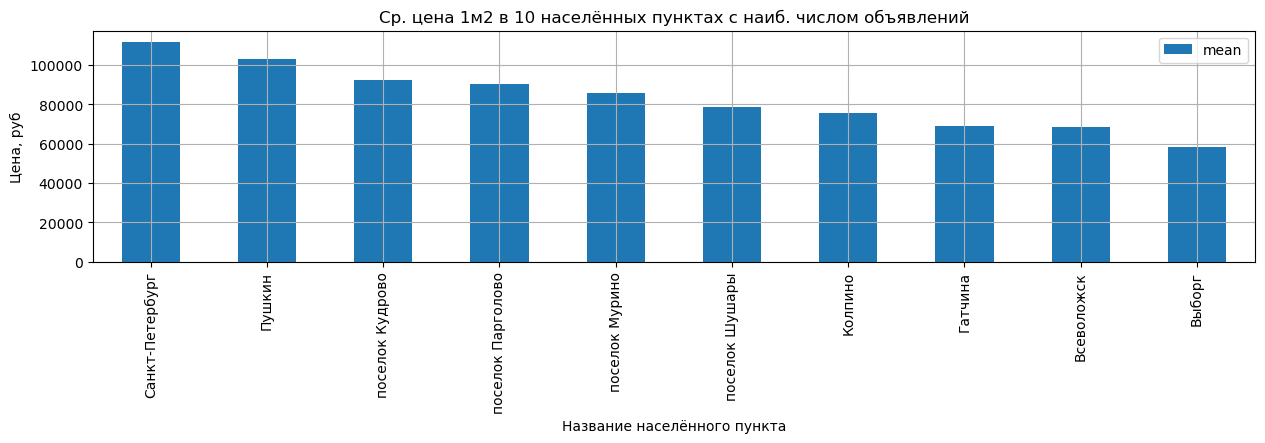

In [108]:
top10.sort_values(by = 'mean',ascending=False).plot(kind = 'bar', y = 'mean', figsize = (15,3), grid = True, 
                                                    title = 'Ср. цена 1м2 в 10 населённых пунктах с наиб. числом объявлений')
plt.xlabel('Название населённого пункта')
plt.ylabel('Цена, руб');

В выборке ТОП10 населенных пунктов по количеству объявлений самая дорогая стоимость за 1м2 в Санкт-Петербурге - 111.8 тыс. руб, самая низкая в Выборге, почти в в два раза дешевле - 58.3 тыс. руб  за 1м2.

***Средняя цена каждого километра до центра Санкт-Петербурга***

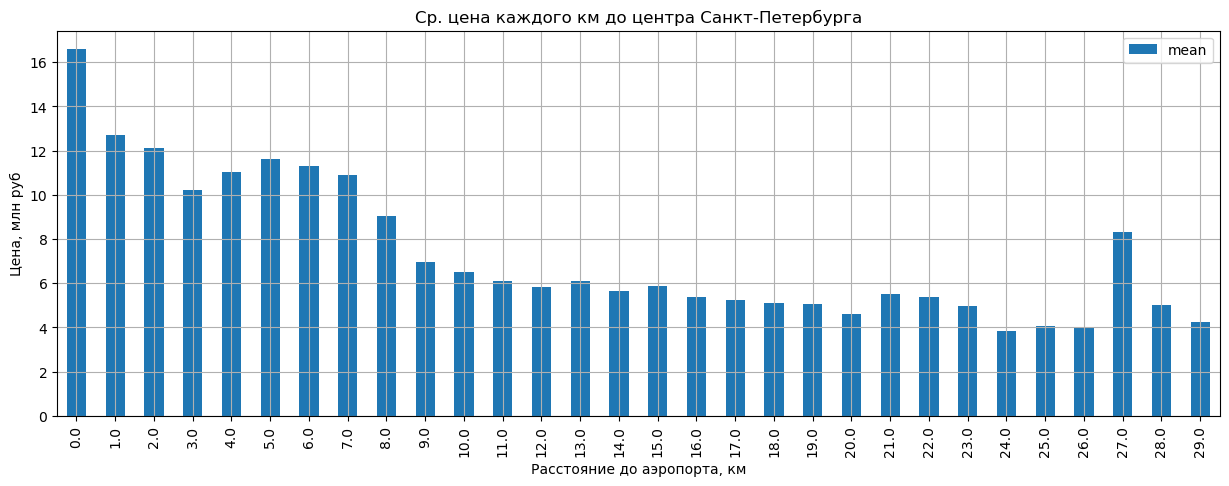

In [109]:
spb_data = data.query('locality_name == "Санкт-Петербург"')
spb_data.pivot_table(index = 'cityCenters_nearest_km', values = 'billion_price', 
                     aggfunc = {'mean'}).plot(kind ='bar', figsize = (15,5), grid = True,
                                             title = 'Ср. цена каждого км до центра Санкт-Петербурга');
plt.xlabel('Расстояние до аэропорта, км')
plt.ylabel('Цена, млн руб');

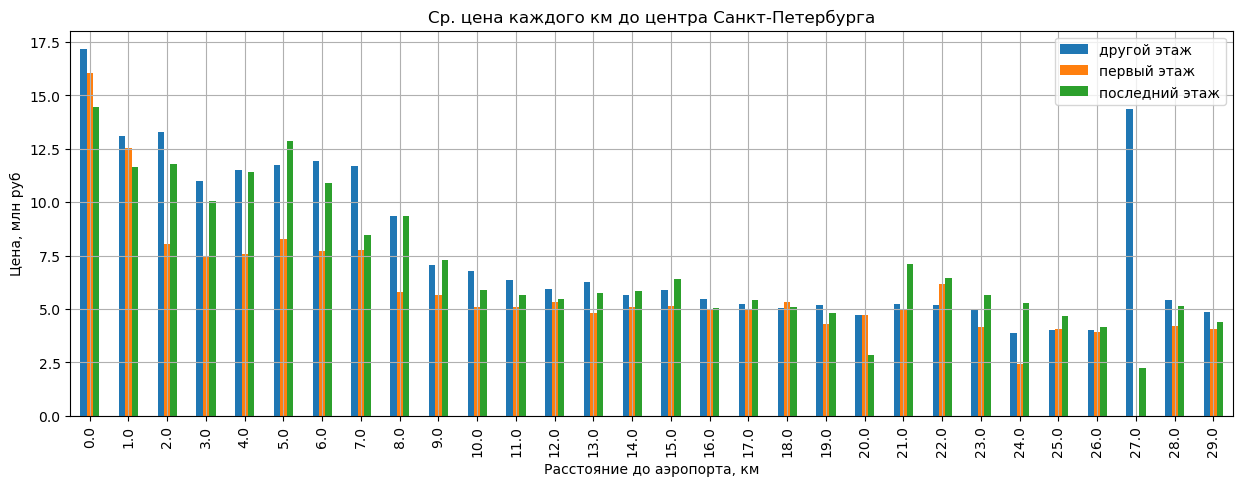

In [110]:
# рассмотрим составляющую типа этажей на каждом километре (по цене)
spb_data.pivot_table(index = 'cityCenters_nearest_km', columns = 'floor_type', values = ['billion_price'], 
                     aggfunc = {'billion_price':'mean'}).plot(figsize = (15,5), kind ='bar', grid = True,
                                             title = 'Ср. цена каждого км до центра Санкт-Петербурга');
plt.xlabel('Расстояние до аэропорта, км')
plt.ylabel('Цена, млн руб')
plt.legend((['другой этаж', 'первый этаж', 'последний этаж']));

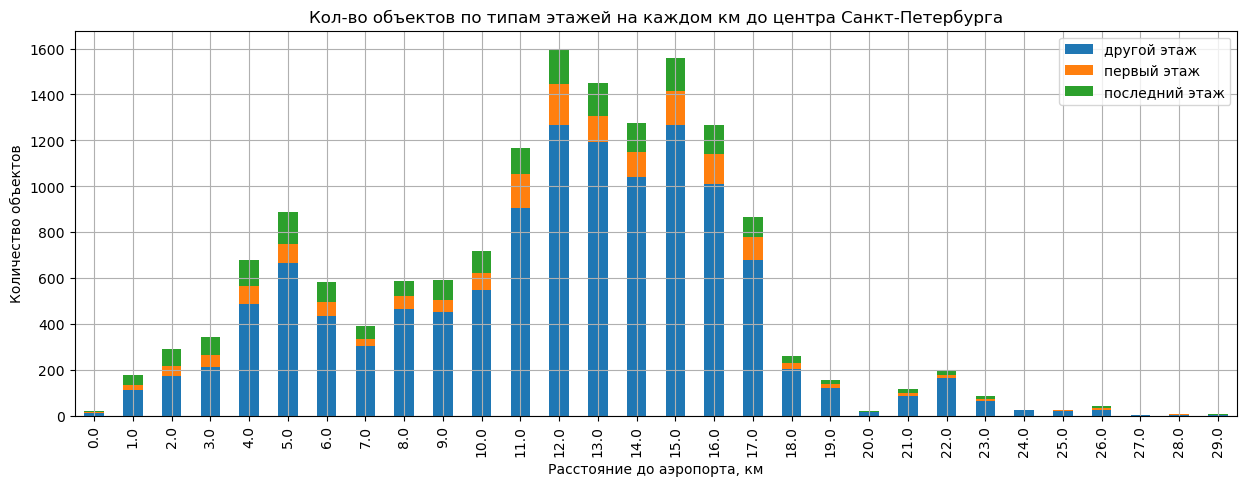

In [111]:
# рассмотрим составляющую типа этажей на каждом километре (по кол-ву значений)
spb_data.pivot_table(index = 'cityCenters_nearest_km', columns = 'floor_type', values = ['billion_price'], 
                     aggfunc = {'billion_price':'count'}).plot(figsize = (15,5), kind ='bar', stacked=True, grid = True,
                                             title = 'Кол-во объектов по типам этажей на каждом км до центра Санкт-Петербурга');
plt.xlabel('Расстояние до аэропорта, км')
plt.ylabel('Количество объектов')
plt.legend((['другой этаж', 'первый этаж', 'последний этаж']));

In [112]:
spb_data.query('cityCenters_nearest_km == 0')['floor_type'].value_counts()

другой       20
последний     4
первый        3
Name: floor_type, dtype: int64

In [113]:
spb_data.query('cityCenters_nearest_km == 27')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,floor2,kitchen_area2,days_exposition2,price_per_sq.m,exposition_day,exposition_month,exposition_year,cityCenters_nearest_km,floor_type,price_per_sq.m_thousands
748,13,14350000.0,74.0,2017-11-28,2,3.13,5,30.0,3,NaN,...,3.0,25.0,128.0,0.193919,1,11,2017,27.0,другой,193918.918919
5961,6,2250000.0,32.0,2018-02-27,1,NaN,2,16.5,2,NaN,...,2.0,7.0,178.0,0.070312,1,2,2018,27.0,последний,70312.500000


На графиках виден общий тренд с уменьшением цены при удалении от центра, а так же неравномерное количество данных на каждом километре: вероятно, большая часть предложений находится в районах с активным строительством, а другие объекты скорее всего больше связаны cо старой застройкой.

Так же ряд интересных особенностей и флуктуаций, на которые стоит обратить внимание:
1. Дорогое жилье в самом центре, средняя цена 16млн
2. Падение цены к 3му км: вероятно, это ветхий старый фонд, коммуналки, но близость к центру позволяет цене оставаться на достаточно высоком уровне
3. Рост цены и объема предложения на 5км, где большую цену имеют объекты жилья на последнем этаже, в отличии от остального тренда, где цена в категории "другие" самая высокая. Возможно, это новые ЖК, достаточно близкие к центру, имеющие хорошую инфраструктуру, например, террасы на верхних этажах, чем и обусловлены описанные особенности
4. Рост объема предложения на 11-17км, вероятно это массовая современная застройка. Так же здесь присутствует бОльшая доля квартир на 1м этаже, что так же поддерживает тренд падения цены: растет расстояние от центра, растет доля менее привлекательных объектов, что приводит к падению средней цены  
5. "горб" на 27км: в выборке всего 2 объекта с ценой 14млн и 2млн, таким образом, это аномалия, которой можно пренебречь

### Общий вывод

Проведена аналитическая работа с данными сервиса Яндекс Недвижимость: предобработка данных, исследованы некоторые параметры, зависимости между ними.

**В ходе предобработки данных были выполнены:**
1. работа с пропущенными значениями: в 17 из 22 столбцов архива недвижимости были пропуски. Пропуски в "количестве балконов" было принято заполнить нулями. Остальные параметры остались без изменений, т.к. пользовательские данные достаточно уникальны и их сложно корректно или невозможно рассчитать аналитически с помощью других столбцов, для заполнения картографических сведений необходима дополнительная интеграция с геоинформационным сервисом.   
2. изменен тип в данных в 3 столбцах: с датами публикации объявление (object в datetime), балконами и общим кол-вом этажей (float to int)
3. обработаны неявные дубликаты в столбце с названием географических объектов: с помощью унификации типа географического объекта переименован 51 объект (вместо 363 стало 313)
4. устранены редкие и выбивающие значения в 9 параметрах: 
    'billion_price', 'total_area2','rooms2','ceiling_height2','floors_total2','living_area2','floor2', 'kitchen_area2','days_exposition2':
    * общая потеря данных после фильтрации составила 0.45%
    * в большинстве параметров отфильтрованы выбросы (min/max)
    * помимо этого, в высоте потолков выполнена корректировка разряда чисел, где очевидна ошибка (например, 32м в 3.2м)


**В ходе исследования параметров, которыми характеризуется рынок недвижимости, выявлены следующие особенности:**
* Распределение частот значений общей и жилой площади имеет три пика, которые вероятно соответствуют количеству комнат в объектах, а также имеет длинный хвост из высоких значений
* Наиболее часто встречаемая площадь кухни находится в диапазоне 5-12м2
* Медианная цена недвижимости - 4.6млн, средняя 5.94млн
* Преобладают 1-2-3 комнатных квартиры
* Наиболее часто встречаемая высота потолков у квартир из базы – 2.3.-2.7м  
* Наибольшее количество квартир находятся на 1-5 этажах, количество первых и последних этажей почти одинаково, примерно по 13%
* Общая этажность – больше всего пяти и девятиэтажек. Вероятно, в ближайшее годы будет расти количество у пиков, которые сейчас уже начинают выделяться: 12, 16 и 25 этажей
* Большая часть объектов недвижимости находится в примерно в 10-17км от центра города
* Расстояние объектов недвижимости до аэропорта распределяется от 0 до 84км, наибольшая встречаемость у расстояния 15-30км 
* Среднее расстояние до парка от объектов из архива – 490м, но данные представлены только по трети объектов
* Публикуют объявления преимущественно в будние дни, наименьшее количество публикаций в мае и январе, наибольшее в феврале-марте.

**Так же выявлены следующие зависимости:** 
* Чаще всего квартиры продаются в срок до 1.5 месяцев, но бывают также очень долгие продажи от 7.5мес и более
* На общую стоимость объекта значительно влияет общая площадь квартиры (r2 = 0.78), чуть меньшую корреляцию показывают другие площади – жилая и кухни (0.69 и 0.6).  
    В тоже время, количество комнат не показывает слабое влияние на общую стоимость – 0.5. 
    Вероятно, такое уменьшение коэффициента корреляции обозначает увеличение роли других факторов 
* Самая меньшая цена жилья соответствует первому этажу, далее ожидаемо идет последний этаж, затем другие
* День и месяц подачи объявления не оказывают влияния на стоимость объектов 
* Динамика средних цен год от года показывает плавное уменьшение цен с 2015г до 2018г, после чего в 2019г появляется небольшой рост. 2014г выбивается из выборки, т.к. метрики «количество объявлений» (низкая) и «средняя общая площадь» (высокая) отличаются от остального массива данных.
* Выделены ТОП10 населенных пунктов по количеству объявлений в базе: лидирует Санкт-Петербург, замыкает десятку Выборг. Самая дорогая цена 1м2 в ТОП10 у Петербурга 111тыс, меньшая стоимость в Выборге – 58 тыс. 
* Средняя цена каждого километра до центра Санкт-Петербурга уменьшается при удалении от центра с 16млн+ до примерно 5млн с флуктуациями, которые обусловлены количеством объявлений в выборке, районами с активной застройкой, а  также доли категории этажей




